# EEGNet

This notebook provides a modified reimplementation of the popular CNN-based EEG classifier: EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
Most modifications include parameter changes to make it better suited for short-length windows as the original paper used input over 2 seconds long.
The knowledge and utilities obtained from experimental notebooks six and seven are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session
   - Results
   - Longer window length 
- Same subject, new session
   - Results
   - Longer window length 
- New subject
   - Results
   - Longer window length

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

#### Results

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

The training plots are given below.
B is dark blue, C is light blue and E is light green.
Convergence is already reached after 500 epochs.

![Accuracy plot](figures/4/samesubject_samesession/accuracy.png)
![Loss plot](figures/4/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

### Longer window length

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)

The performed experiment is equal besides this.
The following results were obtained:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.
Convergence takes more time but is still achieved under 1000 epochs and it becomes apparent that there are now signs of overfitting with divergence occurring.

![Accuracy plot](figures/4/samesubject_samesession_longer_window/accuracy.png)
![Loss plot](figures/4/samesubject_samesession_longer_window/loss.png)

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a 1.5 second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_singlesession_longer_window_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set



In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

#### Results

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

It becomes clear the model is capable of making a decent guess but is far from perfect.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/4/samesubject_newsession/accuracy.png)
![Loss plot](figures/4/samesubject_newsession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

### Longer window length

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)

The performed experiment is equal besides this.
The following results were obtained:


| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.7378 @ epoch 2483                  | 0.6887 @ epoch 204               | 0.6677                                           | 0.674                                             |
| C           | 0.9149 @ epoch 885                   | 0.3764 @ epoch 208               | 0.6392                                           | 0.6267                                            |
| E           | 0.8333 @ epoch 233                   | 0.4867 @ epoch 302               | 0.7707                                           | 0.7812                                            |


The training plots are given below.
B is dark blue, C is light blue and E is green.
Again, there is a clear sign of divergence!

![Accuracy plot](figures/4/samesubject_newsession_longer_window/accuracy.png)
![Loss plot](figures/4/samesubject_newsession_longer_window/loss.png)

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a 1.5 seconds window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsession_longer_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use two participants for training and one for testing
      - Thus, the CV scores are on the test split for the training data (and thus seen participants) whilst the independent test set is from the unseen subject not used during training. 
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set



In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/4/newsubject/accuracy.png)
![Loss plot](figures/4/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

### Longer window length

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)

The performed experiment is equal besides this.
The following results were obtained:


| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.8001 @ epoch 438                   | 0.5408 @ epoch 493               | 0.6219                                           | 0.5979                                            |
| C (Train B&E) | 0.7578 @ epoch 292                   | 0.6006 @ epoch 294               | 0.5839                                           | 0.5714                                            |
| E (Train B&C) | 0.798 @ epoch 2206                   | 0.6026 @ epoch 1848              | 0.6147                                           | 0.6052                                            |


The training plots are given below.
B is dark blue, C is light blue and E is green.
Again, there is a clear sign of divergence!

![Accuracy plot](figures/4/samesubject_newsession_longer_window/accuracy.png)
![Loss plot](figures/4/samesubject_newsession_longer_window/loss.png)

In [5]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a 1.5 seconds window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/newsubject_longer_window/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/newsubject_longer_window/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsubject_long_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/newsubject_longer_window/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Using data from participants ['C', 'E'] to train for testing on participant B
Shape of all training data (epochs, channels, samples): (5751, 21, 300)
Epoch 1/2500
32/32 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.5153
Epoch 1: val_loss improved from inf to 1.02043, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.62399, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 5s 69ms/step - loss: 1.0094 - accuracy: 0.5153 - val_loss: 1.0204 - val_accuracy: 0.6240
Epoch 2/2500
31/32 [============================>.] - ETA: 0s - loss: 0.8494 - accuracy: 0.6522
Epoch 2: val_loss improved from 1.02043 to 0.97396, saving model to saved_variables

Epoch 17/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5110 - accuracy: 0.8203
Epoch 17: val_loss improved from 0.62883 to 0.60699, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.74044
32/32 [==============================] - 2s 49ms/step - loss: 0.5098 - accuracy: 0.8214 - val_loss: 0.6070 - val_accuracy: 0.7404
Epoch 18/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8271
Epoch 18: val_loss did not improve from 0.60699

Epoch 18: val_accuracy improved from 0.74044 to 0.74797, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 49ms/step - loss: 0.5055 - accuracy: 0.8273 - val_loss: 0.6074 - val_accuracy: 0.7480
Epoch 19/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5072 - accuracy: 0.8175
Epoch 19: val_loss did not 


Epoch 39: val_accuracy improved from 0.75319 to 0.76130, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 53ms/step - loss: 0.4338 - accuracy: 0.8450 - val_loss: 0.5834 - val_accuracy: 0.7613
Epoch 40/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.8438
Epoch 40: val_loss did not improve from 0.58344

Epoch 40: val_accuracy did not improve from 0.76130
32/32 [==============================] - 2s 48ms/step - loss: 0.4370 - accuracy: 0.8430 - val_loss: 0.6015 - val_accuracy: 0.7468
Epoch 41/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4268 - accuracy: 0.8513
Epoch 41: val_loss did not improve from 0.58344

Epoch 41: val_accuracy did not improve from 0.76130
32/32 [==============================] - 2s 48ms/step - loss: 0.4263 - accuracy: 0.8514 - val_loss: 0.5843 - val_accuracy: 0.7538
Epoch 42/2500
31/32 [============================>.


Epoch 63: val_accuracy did not improve from 0.76130
32/32 [==============================] - 1s 46ms/step - loss: 0.3374 - accuracy: 0.8832 - val_loss: 0.6822 - val_accuracy: 0.7260
Epoch 64/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8916
Epoch 64: val_loss did not improve from 0.58033

Epoch 64: val_accuracy did not improve from 0.76130
32/32 [==============================] - 1s 46ms/step - loss: 0.3338 - accuracy: 0.8912 - val_loss: 0.6289 - val_accuracy: 0.7491
Epoch 65/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3384 - accuracy: 0.8745
Epoch 65: val_loss did not improve from 0.58033

Epoch 65: val_accuracy did not improve from 0.76130
32/32 [==============================] - 1s 46ms/step - loss: 0.3430 - accuracy: 0.8730 - val_loss: 0.6676 - val_accuracy: 0.7364
Epoch 66/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8798
Epoch 66: val_loss did not improve from 0.58033

Epoch 66: val_a

Epoch 88/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8949
Epoch 88: val_loss did not improve from 0.58033

Epoch 88: val_accuracy did not improve from 0.76477
32/32 [==============================] - 2s 48ms/step - loss: 0.3148 - accuracy: 0.8944 - val_loss: 0.6750 - val_accuracy: 0.7393
Epoch 89/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.8904
Epoch 89: val_loss did not improve from 0.58033

Epoch 89: val_accuracy did not improve from 0.76477
32/32 [==============================] - 1s 47ms/step - loss: 0.3128 - accuracy: 0.8904 - val_loss: 0.6354 - val_accuracy: 0.7578
Epoch 90/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8901
Epoch 90: val_loss did not improve from 0.58033

Epoch 90: val_accuracy improved from 0.76477 to 0.77173, saving model to saved_variables/4/newsubject_longer_window/subjectB\trained_model_highest_acc_model.hdf5
32/32 [=============================

32/32 [==============================] - 1s 46ms/step - loss: 0.2886 - accuracy: 0.9063 - val_loss: 0.6475 - val_accuracy: 0.7567
Epoch 113/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8979
Epoch 113: val_loss did not improve from 0.58033

Epoch 113: val_accuracy did not improve from 0.77173
32/32 [==============================] - 1s 46ms/step - loss: 0.2987 - accuracy: 0.8976 - val_loss: 0.7351 - val_accuracy: 0.7352
Epoch 114/2500
32/32 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8954
Epoch 114: val_loss did not improve from 0.58033

Epoch 114: val_accuracy did not improve from 0.77173
32/32 [==============================] - 1s 47ms/step - loss: 0.2963 - accuracy: 0.8954 - val_loss: 0.6082 - val_accuracy: 0.7607
Epoch 115/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8974
Epoch 115: val_loss did not improve from 0.58033

Epoch 115: val_accuracy did not improve from 0.77173
32/32 [

Epoch 137/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0.8979
Epoch 137: val_loss did not improve from 0.57647

Epoch 137: val_accuracy did not improve from 0.77346
32/32 [==============================] - 2s 57ms/step - loss: 0.2826 - accuracy: 0.8979 - val_loss: 0.6625 - val_accuracy: 0.7457
Epoch 138/2500
32/32 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.9009
Epoch 138: val_loss did not improve from 0.57647

Epoch 138: val_accuracy did not improve from 0.77346
32/32 [==============================] - 2s 53ms/step - loss: 0.2865 - accuracy: 0.9009 - val_loss: 0.6313 - val_accuracy: 0.7491
Epoch 139/2500
32/32 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8999
Epoch 139: val_loss did not improve from 0.57647

Epoch 139: val_accuracy did not improve from 0.77346
32/32 [==============================] - 4s 119ms/step - loss: 0.2847 - accuracy: 0.8999 - val_loss: 0.6441 - val_accuracy: 0.7503
Epoch 

Epoch 186/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.8997
Epoch 186: val_loss did not improve from 0.57202

Epoch 186: val_accuracy did not improve from 0.77810
32/32 [==============================] - 1s 46ms/step - loss: 0.2758 - accuracy: 0.8996 - val_loss: 0.6652 - val_accuracy: 0.7491
Epoch 187/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.9098
Epoch 187: val_loss did not improve from 0.57202

Epoch 187: val_accuracy did not improve from 0.77810
32/32 [==============================] - 1s 47ms/step - loss: 0.2651 - accuracy: 0.9098 - val_loss: 0.6788 - val_accuracy: 0.7462
Epoch 188/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.9045
Epoch 188: val_loss did not improve from 0.57202

Epoch 188: val_accuracy did not improve from 0.77810
32/32 [==============================] - 2s 47ms/step - loss: 0.2680 - accuracy: 0.9043 - val_loss: 0.6251 - val_accuracy: 0.7613
Epoch 1

Epoch 235/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9080
Epoch 235: val_loss did not improve from 0.54268

Epoch 235: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2579 - accuracy: 0.9086 - val_loss: 0.5531 - val_accuracy: 0.7908
Epoch 236/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9095
Epoch 236: val_loss did not improve from 0.54268

Epoch 236: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 47ms/step - loss: 0.2532 - accuracy: 0.9103 - val_loss: 0.6163 - val_accuracy: 0.7717
Epoch 237/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9083
Epoch 237: val_loss did not improve from 0.54268

Epoch 237: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 47ms/step - loss: 0.2479 - accuracy: 0.9086 - val_loss: 0.6179 - val_accuracy: 0.7671
Epoch 2

Epoch 260/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.9085
Epoch 260: val_loss did not improve from 0.54268

Epoch 260: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2419 - accuracy: 0.9083 - val_loss: 0.6040 - val_accuracy: 0.7740
Epoch 261/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9128
Epoch 261: val_loss did not improve from 0.54268

Epoch 261: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2510 - accuracy: 0.9135 - val_loss: 0.6098 - val_accuracy: 0.7613
Epoch 262/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9115
Epoch 262: val_loss did not improve from 0.54268

Epoch 262: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2504 - accuracy: 0.9118 - val_loss: 0.6099 - val_accuracy: 0.7746
Epoch 2

Epoch 285/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.9128
Epoch 285: val_loss did not improve from 0.54268

Epoch 285: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 50ms/step - loss: 0.2463 - accuracy: 0.9125 - val_loss: 0.5774 - val_accuracy: 0.7775
Epoch 286/2500
32/32 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9078
Epoch 286: val_loss did not improve from 0.54268

Epoch 286: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 52ms/step - loss: 0.2509 - accuracy: 0.9078 - val_loss: 0.6212 - val_accuracy: 0.7654
Epoch 287/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9113
Epoch 287: val_loss did not improve from 0.54268

Epoch 287: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 45ms/step - loss: 0.2424 - accuracy: 0.9106 - val_loss: 0.6199 - val_accuracy: 0.7619
Epoch 2

Epoch 310/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.9110
Epoch 310: val_loss did not improve from 0.54268

Epoch 310: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2478 - accuracy: 0.9118 - val_loss: 0.5980 - val_accuracy: 0.7775
Epoch 311/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9252
Epoch 311: val_loss did not improve from 0.54268

Epoch 311: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 45ms/step - loss: 0.2268 - accuracy: 0.9252 - val_loss: 0.6365 - val_accuracy: 0.7671
Epoch 312/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9181
Epoch 312: val_loss did not improve from 0.54268

Epoch 312: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2328 - accuracy: 0.9170 - val_loss: 0.6654 - val_accuracy: 0.7555
Epoch 3

Epoch 335/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9143
Epoch 335: val_loss did not improve from 0.54268

Epoch 335: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2316 - accuracy: 0.9133 - val_loss: 0.6067 - val_accuracy: 0.7729
Epoch 336/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9221
Epoch 336: val_loss did not improve from 0.54268

Epoch 336: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2263 - accuracy: 0.9212 - val_loss: 0.6273 - val_accuracy: 0.7677
Epoch 337/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9178
Epoch 337: val_loss did not improve from 0.54268

Epoch 337: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2344 - accuracy: 0.9180 - val_loss: 0.5749 - val_accuracy: 0.7851
Epoch 3

Epoch 360/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9163
Epoch 360: val_loss did not improve from 0.54268

Epoch 360: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2322 - accuracy: 0.9173 - val_loss: 0.6255 - val_accuracy: 0.7654
Epoch 361/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9158
Epoch 361: val_loss did not improve from 0.54268

Epoch 361: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2446 - accuracy: 0.9158 - val_loss: 0.6246 - val_accuracy: 0.7619
Epoch 362/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2426 - accuracy: 0.9128
Epoch 362: val_loss did not improve from 0.54268

Epoch 362: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2435 - accuracy: 0.9133 - val_loss: 0.5829 - val_accuracy: 0.7735
Epoch 3

Epoch 385/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9163
Epoch 385: val_loss did not improve from 0.54268

Epoch 385: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 47ms/step - loss: 0.2203 - accuracy: 0.9163 - val_loss: 0.6056 - val_accuracy: 0.7717
Epoch 386/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9229
Epoch 386: val_loss did not improve from 0.54268

Epoch 386: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 48ms/step - loss: 0.2247 - accuracy: 0.9227 - val_loss: 0.5518 - val_accuracy: 0.7897
Epoch 387/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9181
Epoch 387: val_loss did not improve from 0.54268

Epoch 387: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 47ms/step - loss: 0.2261 - accuracy: 0.9190 - val_loss: 0.5894 - val_accuracy: 0.7833
Epoch 3

Epoch 410/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9206
Epoch 410: val_loss did not improve from 0.54268

Epoch 410: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2206 - accuracy: 0.9210 - val_loss: 0.5779 - val_accuracy: 0.7804
Epoch 411/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2169 - accuracy: 0.9204
Epoch 411: val_loss did not improve from 0.54268

Epoch 411: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 46ms/step - loss: 0.2169 - accuracy: 0.9202 - val_loss: 0.6564 - val_accuracy: 0.7619
Epoch 412/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9239
Epoch 412: val_loss did not improve from 0.54268

Epoch 412: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 45ms/step - loss: 0.2188 - accuracy: 0.9215 - val_loss: 0.6098 - val_accuracy: 0.7729
Epoch 4

Epoch 435/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9146
Epoch 435: val_loss did not improve from 0.54268

Epoch 435: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 47ms/step - loss: 0.2285 - accuracy: 0.9150 - val_loss: 0.5914 - val_accuracy: 0.7735
Epoch 436/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9156
Epoch 436: val_loss did not improve from 0.54268

Epoch 436: val_accuracy did not improve from 0.79200
32/32 [==============================] - 2s 47ms/step - loss: 0.2209 - accuracy: 0.9153 - val_loss: 0.5748 - val_accuracy: 0.7833
Epoch 437/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9224
Epoch 437: val_loss did not improve from 0.54268

Epoch 437: val_accuracy did not improve from 0.79200
32/32 [==============================] - 1s 47ms/step - loss: 0.2160 - accuracy: 0.9220 - val_loss: 0.5966 - val_accuracy: 0.7706
Epoch 4

Epoch 484/2500
32/32 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9225
Epoch 484: val_loss did not improve from 0.54219

Epoch 484: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 51ms/step - loss: 0.2157 - accuracy: 0.9225 - val_loss: 0.5672 - val_accuracy: 0.7851
Epoch 485/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9204
Epoch 485: val_loss did not improve from 0.54219

Epoch 485: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.2188 - accuracy: 0.9202 - val_loss: 0.5815 - val_accuracy: 0.7862
Epoch 486/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9254
Epoch 486: val_loss did not improve from 0.54219

Epoch 486: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.2124 - accuracy: 0.9250 - val_loss: 0.6077 - val_accuracy: 0.7723
Epoch 4


Epoch 508: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 49ms/step - loss: 0.2088 - accuracy: 0.9245 - val_loss: 0.5670 - val_accuracy: 0.7862
Epoch 509/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9269
Epoch 509: val_loss did not improve from 0.54076

Epoch 509: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.2054 - accuracy: 0.9272 - val_loss: 0.5558 - val_accuracy: 0.7908
Epoch 510/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9176
Epoch 510: val_loss did not improve from 0.54076

Epoch 510: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.2163 - accuracy: 0.9175 - val_loss: 0.5665 - val_accuracy: 0.7787
Epoch 511/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1990 - accuracy: 0.9252
Epoch 511: val_loss did not improve from 0.54076

Epoch 

Epoch 558/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.9287
Epoch 558: val_loss did not improve from 0.54076

Epoch 558: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.2034 - accuracy: 0.9289 - val_loss: 0.5914 - val_accuracy: 0.7839
Epoch 559/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9304
Epoch 559: val_loss did not improve from 0.54076

Epoch 559: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.2102 - accuracy: 0.9302 - val_loss: 0.6228 - val_accuracy: 0.7740
Epoch 560/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9252
Epoch 560: val_loss did not improve from 0.54076

Epoch 560: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.2057 - accuracy: 0.9257 - val_loss: 0.6099 - val_accuracy: 0.7648
Epoch 5

Epoch 583/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9252
Epoch 583: val_loss did not improve from 0.54076

Epoch 583: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2035 - accuracy: 0.9250 - val_loss: 0.5864 - val_accuracy: 0.7827
Epoch 584/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9239
Epoch 584: val_loss did not improve from 0.54076

Epoch 584: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2070 - accuracy: 0.9240 - val_loss: 0.6446 - val_accuracy: 0.7625
Epoch 585/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9272
Epoch 585: val_loss did not improve from 0.54076

Epoch 585: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.2008 - accuracy: 0.9267 - val_loss: 0.6146 - val_accuracy: 0.7781
Epoch 5

Epoch 608/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9231
Epoch 608: val_loss did not improve from 0.54076

Epoch 608: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2173 - accuracy: 0.9225 - val_loss: 0.5450 - val_accuracy: 0.7862
Epoch 609/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9178
Epoch 609: val_loss did not improve from 0.54076

Epoch 609: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2131 - accuracy: 0.9183 - val_loss: 0.5985 - val_accuracy: 0.7706
Epoch 610/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9272
Epoch 610: val_loss did not improve from 0.54076

Epoch 610: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2104 - accuracy: 0.9270 - val_loss: 0.5897 - val_accuracy: 0.7816
Epoch 6

Epoch 633/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9284
Epoch 633: val_loss did not improve from 0.54076

Epoch 633: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1935 - accuracy: 0.9282 - val_loss: 0.5804 - val_accuracy: 0.7839
Epoch 634/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9307
Epoch 634: val_loss did not improve from 0.54076

Epoch 634: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1909 - accuracy: 0.9312 - val_loss: 0.6329 - val_accuracy: 0.7723
Epoch 635/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9272
Epoch 635: val_loss did not improve from 0.54076

Epoch 635: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1966 - accuracy: 0.9265 - val_loss: 0.5946 - val_accuracy: 0.7793
Epoch 6

Epoch 658/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9239
Epoch 658: val_loss did not improve from 0.54076

Epoch 658: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1976 - accuracy: 0.9245 - val_loss: 0.6508 - val_accuracy: 0.7520
Epoch 659/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9292
Epoch 659: val_loss did not improve from 0.54076

Epoch 659: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.2056 - accuracy: 0.9294 - val_loss: 0.6536 - val_accuracy: 0.7572
Epoch 660/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1935 - accuracy: 0.9259
Epoch 660: val_loss did not improve from 0.54076

Epoch 660: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1942 - accuracy: 0.9255 - val_loss: 0.6159 - val_accuracy: 0.7654
Epoch 6

Epoch 683/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9239
Epoch 683: val_loss did not improve from 0.54076

Epoch 683: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2023 - accuracy: 0.9240 - val_loss: 0.5955 - val_accuracy: 0.7711
Epoch 684/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9249
Epoch 684: val_loss did not improve from 0.54076

Epoch 684: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2047 - accuracy: 0.9250 - val_loss: 0.6279 - val_accuracy: 0.7642
Epoch 685/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9216
Epoch 685: val_loss did not improve from 0.54076

Epoch 685: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1968 - accuracy: 0.9217 - val_loss: 0.6401 - val_accuracy: 0.7619
Epoch 6

Epoch 708/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9246
Epoch 708: val_loss did not improve from 0.54076

Epoch 708: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2001 - accuracy: 0.9255 - val_loss: 0.6141 - val_accuracy: 0.7746
Epoch 709/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9262
Epoch 709: val_loss did not improve from 0.54076

Epoch 709: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.2031 - accuracy: 0.9260 - val_loss: 0.6041 - val_accuracy: 0.7769
Epoch 710/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9252
Epoch 710: val_loss did not improve from 0.54076

Epoch 710: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1947 - accuracy: 0.9255 - val_loss: 0.5929 - val_accuracy: 0.7729
Epoch 7

Epoch 733/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9302
Epoch 733: val_loss did not improve from 0.54076

Epoch 733: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1975 - accuracy: 0.9304 - val_loss: 0.6090 - val_accuracy: 0.7677
Epoch 734/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9367
Epoch 734: val_loss did not improve from 0.54076

Epoch 734: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1790 - accuracy: 0.9366 - val_loss: 0.5977 - val_accuracy: 0.7816
Epoch 735/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9289
Epoch 735: val_loss did not improve from 0.54076

Epoch 735: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1911 - accuracy: 0.9287 - val_loss: 0.6085 - val_accuracy: 0.7694
Epoch 7

Epoch 758/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9317
Epoch 758: val_loss did not improve from 0.54076

Epoch 758: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1948 - accuracy: 0.9314 - val_loss: 0.5986 - val_accuracy: 0.7764
Epoch 759/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9246
Epoch 759: val_loss did not improve from 0.54076

Epoch 759: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1911 - accuracy: 0.9255 - val_loss: 0.6114 - val_accuracy: 0.7752
Epoch 760/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9330
Epoch 760: val_loss did not improve from 0.54076

Epoch 760: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1972 - accuracy: 0.9319 - val_loss: 0.5792 - val_accuracy: 0.7839
Epoch 7

Epoch 783/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9320
Epoch 783: val_loss did not improve from 0.54076

Epoch 783: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1830 - accuracy: 0.9317 - val_loss: 0.6235 - val_accuracy: 0.7723
Epoch 784/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1900 - accuracy: 0.9307
Epoch 784: val_loss did not improve from 0.54076

Epoch 784: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1902 - accuracy: 0.9312 - val_loss: 0.6253 - val_accuracy: 0.7659
Epoch 785/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9315
Epoch 785: val_loss did not improve from 0.54076

Epoch 785: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1826 - accuracy: 0.9317 - val_loss: 0.6000 - val_accuracy: 0.7775
Epoch 7

Epoch 808/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1852 - accuracy: 0.9322
Epoch 808: val_loss did not improve from 0.54076

Epoch 808: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1852 - accuracy: 0.9319 - val_loss: 0.6085 - val_accuracy: 0.7746
Epoch 809/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9307
Epoch 809: val_loss did not improve from 0.54076

Epoch 809: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1912 - accuracy: 0.9309 - val_loss: 0.6579 - val_accuracy: 0.7648
Epoch 810/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9307
Epoch 810: val_loss did not improve from 0.54076

Epoch 810: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1907 - accuracy: 0.9302 - val_loss: 0.5956 - val_accuracy: 0.7729
Epoch 8

Epoch 833/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9284
Epoch 833: val_loss did not improve from 0.54076

Epoch 833: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1955 - accuracy: 0.9282 - val_loss: 0.6516 - val_accuracy: 0.7671
Epoch 834/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9279
Epoch 834: val_loss did not improve from 0.54076

Epoch 834: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1874 - accuracy: 0.9277 - val_loss: 0.6027 - val_accuracy: 0.7775
Epoch 835/2500
32/32 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9319
Epoch 835: val_loss did not improve from 0.54076

Epoch 835: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1831 - accuracy: 0.9319 - val_loss: 0.6176 - val_accuracy: 0.7677
Epoch 8

Epoch 858/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9337
Epoch 858: val_loss did not improve from 0.54076

Epoch 858: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1804 - accuracy: 0.9347 - val_loss: 0.6659 - val_accuracy: 0.7590
Epoch 859/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9367
Epoch 859: val_loss did not improve from 0.54076

Epoch 859: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1848 - accuracy: 0.9366 - val_loss: 0.6373 - val_accuracy: 0.7648
Epoch 860/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9309
Epoch 860: val_loss did not improve from 0.54076

Epoch 860: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1929 - accuracy: 0.9312 - val_loss: 0.5682 - val_accuracy: 0.7769
Epoch 8

Epoch 883/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9299
Epoch 883: val_loss did not improve from 0.54076

Epoch 883: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1911 - accuracy: 0.9299 - val_loss: 0.6193 - val_accuracy: 0.7729
Epoch 884/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9355
Epoch 884: val_loss did not improve from 0.54076

Epoch 884: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1877 - accuracy: 0.9354 - val_loss: 0.5966 - val_accuracy: 0.7781
Epoch 885/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9320
Epoch 885: val_loss did not improve from 0.54076

Epoch 885: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1940 - accuracy: 0.9314 - val_loss: 0.6260 - val_accuracy: 0.7596
Epoch 8

Epoch 908/2500
31/32 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9236
Epoch 908: val_loss did not improve from 0.54076

Epoch 908: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 44ms/step - loss: 0.2011 - accuracy: 0.9235 - val_loss: 0.6211 - val_accuracy: 0.7636
Epoch 909/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9355
Epoch 909: val_loss did not improve from 0.54076

Epoch 909: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1757 - accuracy: 0.9359 - val_loss: 0.6491 - val_accuracy: 0.7596
Epoch 910/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9352
Epoch 910: val_loss did not improve from 0.54076

Epoch 910: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 44ms/step - loss: 0.1785 - accuracy: 0.9344 - val_loss: 0.6433 - val_accuracy: 0.7636
Epoch 9

Epoch 933/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9272
Epoch 933: val_loss did not improve from 0.54076

Epoch 933: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1885 - accuracy: 0.9277 - val_loss: 0.6141 - val_accuracy: 0.7787
Epoch 934/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9335
Epoch 934: val_loss did not improve from 0.54076

Epoch 934: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1852 - accuracy: 0.9327 - val_loss: 0.6472 - val_accuracy: 0.7567
Epoch 935/2500
32/32 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9327
Epoch 935: val_loss did not improve from 0.54076

Epoch 935: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 50ms/step - loss: 0.1811 - accuracy: 0.9327 - val_loss: 0.6540 - val_accuracy: 0.7729
Epoch 9

Epoch 958/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9367
Epoch 958: val_loss did not improve from 0.54076

Epoch 958: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1804 - accuracy: 0.9369 - val_loss: 0.6242 - val_accuracy: 0.7723
Epoch 959/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9297
Epoch 959: val_loss did not improve from 0.54076

Epoch 959: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1958 - accuracy: 0.9297 - val_loss: 0.6047 - val_accuracy: 0.7636
Epoch 960/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9279
Epoch 960: val_loss did not improve from 0.54076

Epoch 960: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1829 - accuracy: 0.9287 - val_loss: 0.6283 - val_accuracy: 0.7700
Epoch 9

Epoch 983/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9383
Epoch 983: val_loss did not improve from 0.54076

Epoch 983: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1755 - accuracy: 0.9379 - val_loss: 0.6019 - val_accuracy: 0.7781
Epoch 984/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9332
Epoch 984: val_loss did not improve from 0.54076

Epoch 984: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1860 - accuracy: 0.9329 - val_loss: 0.6061 - val_accuracy: 0.7636
Epoch 985/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9322
Epoch 985: val_loss did not improve from 0.54076

Epoch 985: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1908 - accuracy: 0.9322 - val_loss: 0.6386 - val_accuracy: 0.7555
Epoch 9

Epoch 1008/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9299
Epoch 1008: val_loss did not improve from 0.54076

Epoch 1008: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1907 - accuracy: 0.9304 - val_loss: 0.6238 - val_accuracy: 0.7735
Epoch 1009/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9365
Epoch 1009: val_loss did not improve from 0.54076

Epoch 1009: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1735 - accuracy: 0.9364 - val_loss: 0.5878 - val_accuracy: 0.7810
Epoch 1010/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9367
Epoch 1010: val_loss did not improve from 0.54076

Epoch 1010: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1761 - accuracy: 0.9371 - val_loss: 0.6250 - val_accuracy: 0.769

32/32 [==============================] - 1s 46ms/step - loss: 0.1765 - accuracy: 0.9334 - val_loss: 0.6192 - val_accuracy: 0.7740
Epoch 1033/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9347
Epoch 1033: val_loss did not improve from 0.54076

Epoch 1033: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1802 - accuracy: 0.9347 - val_loss: 0.6623 - val_accuracy: 0.7555
Epoch 1034/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9320
Epoch 1034: val_loss did not improve from 0.54076

Epoch 1034: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1818 - accuracy: 0.9309 - val_loss: 0.6212 - val_accuracy: 0.7648
Epoch 1035/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9289
Epoch 1035: val_loss did not improve from 0.54076

Epoch 1035: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1758 - accuracy: 0.9374 - val_loss: 0.6662 - val_accuracy: 0.7648
Epoch 1082/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9388
Epoch 1082: val_loss did not improve from 0.54076

Epoch 1082: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 57ms/step - loss: 0.1670 - accuracy: 0.9396 - val_loss: 0.6334 - val_accuracy: 0.7740
Epoch 1083/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9317
Epoch 1083: val_loss did not improve from 0.54076

Epoch 1083: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1833 - accuracy: 0.9317 - val_loss: 0.6434 - val_accuracy: 0.7659
Epoch 1084/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9350
Epoch 1084: val_loss did not improve from 0.54076

Epoch 1084: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 47ms/step - loss: 0.1661 - accuracy: 0.9431 - val_loss: 0.6470 - val_accuracy: 0.7642
Epoch 1131/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9403
Epoch 1131: val_loss did not improve from 0.54076

Epoch 1131: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 49ms/step - loss: 0.1708 - accuracy: 0.9401 - val_loss: 0.6290 - val_accuracy: 0.7648
Epoch 1132/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9355
Epoch 1132: val_loss did not improve from 0.54076

Epoch 1132: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1869 - accuracy: 0.9357 - val_loss: 0.6417 - val_accuracy: 0.7688
Epoch 1133/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9312
Epoch 1133: val_loss did not improve from 0.54076

Epoch 1133: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 49ms/step - loss: 0.1629 - accuracy: 0.9414 - val_loss: 0.6499 - val_accuracy: 0.7683
Epoch 1180/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9405
Epoch 1180: val_loss did not improve from 0.54076

Epoch 1180: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 49ms/step - loss: 0.1635 - accuracy: 0.9409 - val_loss: 0.6350 - val_accuracy: 0.7827
Epoch 1181/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9375
Epoch 1181: val_loss did not improve from 0.54076

Epoch 1181: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 49ms/step - loss: 0.1755 - accuracy: 0.9366 - val_loss: 0.6176 - val_accuracy: 0.7677
Epoch 1182/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9320
Epoch 1182: val_loss did not improve from 0.54076

Epoch 1182: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1649 - accuracy: 0.9391 - val_loss: 0.6295 - val_accuracy: 0.7781
Epoch 1229/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9355
Epoch 1229: val_loss did not improve from 0.54076

Epoch 1229: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1664 - accuracy: 0.9361 - val_loss: 0.6300 - val_accuracy: 0.7636
Epoch 1230/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9365
Epoch 1230: val_loss did not improve from 0.54076

Epoch 1230: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1780 - accuracy: 0.9369 - val_loss: 0.6489 - val_accuracy: 0.7630
Epoch 1231/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9362
Epoch 1231: val_loss did not improve from 0.54076

Epoch 1231: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1796 - accuracy: 0.9314 - val_loss: 0.6207 - val_accuracy: 0.7735
Epoch 1278/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9335
Epoch 1278: val_loss did not improve from 0.54076

Epoch 1278: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1732 - accuracy: 0.9334 - val_loss: 0.6304 - val_accuracy: 0.7683
Epoch 1279/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9383
Epoch 1279: val_loss did not improve from 0.54076

Epoch 1279: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1765 - accuracy: 0.9389 - val_loss: 0.6551 - val_accuracy: 0.7601
Epoch 1280/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9441
Epoch 1280: val_loss did not improve from 0.54076

Epoch 1280: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1699 - accuracy: 0.9369 - val_loss: 0.6106 - val_accuracy: 0.7729
Epoch 1327/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9400
Epoch 1327: val_loss did not improve from 0.54076

Epoch 1327: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 49ms/step - loss: 0.1606 - accuracy: 0.9399 - val_loss: 0.6343 - val_accuracy: 0.7735
Epoch 1328/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9415
Epoch 1328: val_loss did not improve from 0.54076

Epoch 1328: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1669 - accuracy: 0.9424 - val_loss: 0.6204 - val_accuracy: 0.7758
Epoch 1329/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9287
Epoch 1329: val_loss did not improve from 0.54076

Epoch 1329: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 47ms/step - loss: 0.1670 - accuracy: 0.9434 - val_loss: 0.6416 - val_accuracy: 0.7590
Epoch 1376/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9430
Epoch 1376: val_loss did not improve from 0.54076

Epoch 1376: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1657 - accuracy: 0.9439 - val_loss: 0.6360 - val_accuracy: 0.7642
Epoch 1377/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9383
Epoch 1377: val_loss did not improve from 0.54076

Epoch 1377: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1721 - accuracy: 0.9379 - val_loss: 0.6300 - val_accuracy: 0.7636
Epoch 1378/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9423
Epoch 1378: val_loss did not improve from 0.54076

Epoch 1378: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1620 - accuracy: 0.9424 - val_loss: 0.6502 - val_accuracy: 0.7717
Epoch 1425/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9335
Epoch 1425: val_loss did not improve from 0.54076

Epoch 1425: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1791 - accuracy: 0.9332 - val_loss: 0.6048 - val_accuracy: 0.7740
Epoch 1426/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9372
Epoch 1426: val_loss did not improve from 0.54076

Epoch 1426: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1751 - accuracy: 0.9376 - val_loss: 0.6706 - val_accuracy: 0.7555
Epoch 1427/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9350
Epoch 1427: val_loss did not improve from 0.54076

Epoch 1427: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1768 - accuracy: 0.9359 - val_loss: 0.6441 - val_accuracy: 0.7584
Epoch 1474/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9362
Epoch 1474: val_loss did not improve from 0.54076

Epoch 1474: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1668 - accuracy: 0.9359 - val_loss: 0.6560 - val_accuracy: 0.7601
Epoch 1475/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9418
Epoch 1475: val_loss did not improve from 0.54076

Epoch 1475: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1600 - accuracy: 0.9421 - val_loss: 0.6638 - val_accuracy: 0.7630
Epoch 1476/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9456
Epoch 1476: val_loss did not improve from 0.54076

Epoch 1476: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1617 - accuracy: 0.9371 - val_loss: 0.6563 - val_accuracy: 0.7665
Epoch 1523/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1647 - accuracy: 0.9385
Epoch 1523: val_loss did not improve from 0.54076

Epoch 1523: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1644 - accuracy: 0.9386 - val_loss: 0.6318 - val_accuracy: 0.7636
Epoch 1524/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9441
Epoch 1524: val_loss did not improve from 0.54076

Epoch 1524: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1557 - accuracy: 0.9448 - val_loss: 0.5908 - val_accuracy: 0.7851
Epoch 1525/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1548 - accuracy: 0.9403
Epoch 1525: val_loss did not improve from 0.54076

Epoch 1525: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 47ms/step - loss: 0.1756 - accuracy: 0.9364 - val_loss: 0.6584 - val_accuracy: 0.7532
Epoch 1572/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9408
Epoch 1572: val_loss did not improve from 0.54076

Epoch 1572: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1670 - accuracy: 0.9409 - val_loss: 0.6323 - val_accuracy: 0.7532
Epoch 1573/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9458
Epoch 1573: val_loss did not improve from 0.54076

Epoch 1573: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1531 - accuracy: 0.9458 - val_loss: 0.6366 - val_accuracy: 0.7671
Epoch 1574/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9372
Epoch 1574: val_loss did not improve from 0.54076

Epoch 1574: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1556 - accuracy: 0.9448 - val_loss: 0.6820 - val_accuracy: 0.7601
Epoch 1621/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9423
Epoch 1621: val_loss did not improve from 0.54076

Epoch 1621: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1609 - accuracy: 0.9421 - val_loss: 0.6364 - val_accuracy: 0.7561
Epoch 1622/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9486
Epoch 1622: val_loss did not improve from 0.54076

Epoch 1622: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1488 - accuracy: 0.9483 - val_loss: 0.6681 - val_accuracy: 0.7700
Epoch 1623/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9393
Epoch 1623: val_loss did not improve from 0.54076

Epoch 1623: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1787 - accuracy: 0.9339 - val_loss: 0.6084 - val_accuracy: 0.7619
Epoch 1670/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9400
Epoch 1670: val_loss did not improve from 0.54076

Epoch 1670: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1548 - accuracy: 0.9404 - val_loss: 0.6648 - val_accuracy: 0.7677
Epoch 1671/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9435
Epoch 1671: val_loss did not improve from 0.54076

Epoch 1671: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1520 - accuracy: 0.9434 - val_loss: 0.6799 - val_accuracy: 0.7613
Epoch 1672/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9456
Epoch 1672: val_loss did not improve from 0.54076

Epoch 1672: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1499 - accuracy: 0.9453 - val_loss: 0.6996 - val_accuracy: 0.7509
Epoch 1719/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9405
Epoch 1719: val_loss did not improve from 0.54076

Epoch 1719: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1598 - accuracy: 0.9399 - val_loss: 0.6531 - val_accuracy: 0.7717
Epoch 1720/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9516
Epoch 1720: val_loss did not improve from 0.54076

Epoch 1720: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1483 - accuracy: 0.9516 - val_loss: 0.7069 - val_accuracy: 0.7567
Epoch 1721/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9403
Epoch 1721: val_loss did not improve from 0.54076

Epoch 1721: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 47ms/step - loss: 0.1581 - accuracy: 0.9443 - val_loss: 0.6481 - val_accuracy: 0.7700
Epoch 1768/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9375
Epoch 1768: val_loss did not improve from 0.54076

Epoch 1768: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1639 - accuracy: 0.9379 - val_loss: 0.6628 - val_accuracy: 0.7654
Epoch 1769/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9330
Epoch 1769: val_loss did not improve from 0.54076

Epoch 1769: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1741 - accuracy: 0.9337 - val_loss: 0.6459 - val_accuracy: 0.7584
Epoch 1770/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9456
Epoch 1770: val_loss did not improve from 0.54076

Epoch 1770: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1399 - accuracy: 0.9486 - val_loss: 0.6801 - val_accuracy: 0.7578
Epoch 1817/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9400
Epoch 1817: val_loss did not improve from 0.54076

Epoch 1817: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1631 - accuracy: 0.9401 - val_loss: 0.6651 - val_accuracy: 0.7555
Epoch 1818/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9403
Epoch 1818: val_loss did not improve from 0.54076

Epoch 1818: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1591 - accuracy: 0.9409 - val_loss: 0.6562 - val_accuracy: 0.7654
Epoch 1819/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9390
Epoch 1819: val_loss did not improve from 0.54076

Epoch 1819: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1553 - accuracy: 0.9439 - val_loss: 0.6340 - val_accuracy: 0.7654
Epoch 1866/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9433
Epoch 1866: val_loss did not improve from 0.54076

Epoch 1866: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1536 - accuracy: 0.9434 - val_loss: 0.6699 - val_accuracy: 0.7480
Epoch 1867/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9446
Epoch 1867: val_loss did not improve from 0.54076

Epoch 1867: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1545 - accuracy: 0.9441 - val_loss: 0.6254 - val_accuracy: 0.7683
Epoch 1868/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9435
Epoch 1868: val_loss did not improve from 0.54076

Epoch 1868: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 45ms/step - loss: 0.1550 - accuracy: 0.9436 - val_loss: 0.6524 - val_accuracy: 0.7578
Epoch 1915/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9410
Epoch 1915: val_loss did not improve from 0.54076

Epoch 1915: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1596 - accuracy: 0.9411 - val_loss: 0.6846 - val_accuracy: 0.7520
Epoch 1916/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9435
Epoch 1916: val_loss did not improve from 0.54076

Epoch 1916: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 45ms/step - loss: 0.1563 - accuracy: 0.9434 - val_loss: 0.6010 - val_accuracy: 0.7683
Epoch 1917/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9423
Epoch 1917: val_loss did not improve from 0.54076

Epoch 1917: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1506 - accuracy: 0.9434 - val_loss: 0.6300 - val_accuracy: 0.7683
Epoch 1964/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9395
Epoch 1964: val_loss did not improve from 0.54076

Epoch 1964: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1627 - accuracy: 0.9394 - val_loss: 0.6026 - val_accuracy: 0.7740
Epoch 1965/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9438
Epoch 1965: val_loss did not improve from 0.54076

Epoch 1965: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1521 - accuracy: 0.9434 - val_loss: 0.6779 - val_accuracy: 0.7613
Epoch 1966/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9420
Epoch 1966: val_loss did not improve from 0.54076

Epoch 1966: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1505 - accuracy: 0.9453 - val_loss: 0.6355 - val_accuracy: 0.7740
Epoch 2013/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9425
Epoch 2013: val_loss did not improve from 0.54076

Epoch 2013: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1573 - accuracy: 0.9421 - val_loss: 0.6012 - val_accuracy: 0.7746
Epoch 2014/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9370
Epoch 2014: val_loss did not improve from 0.54076

Epoch 2014: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1651 - accuracy: 0.9364 - val_loss: 0.6267 - val_accuracy: 0.7677
Epoch 2015/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9433
Epoch 2015: val_loss did not improve from 0.54076

Epoch 2015: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 47ms/step - loss: 0.1482 - accuracy: 0.9451 - val_loss: 0.6372 - val_accuracy: 0.7659
Epoch 2062/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9423
Epoch 2062: val_loss did not improve from 0.54076

Epoch 2062: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1547 - accuracy: 0.9419 - val_loss: 0.6268 - val_accuracy: 0.7683
Epoch 2063/2500
32/32 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9419
Epoch 2063: val_loss did not improve from 0.54076

Epoch 2063: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 48ms/step - loss: 0.1631 - accuracy: 0.9419 - val_loss: 0.6867 - val_accuracy: 0.7491
Epoch 2064/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9463
Epoch 2064: val_loss did not improve from 0.54076

Epoch 2064: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1448 - accuracy: 0.9456 - val_loss: 0.6605 - val_accuracy: 0.7601
Epoch 2111/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9473
Epoch 2111: val_loss did not improve from 0.54076

Epoch 2111: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1469 - accuracy: 0.9478 - val_loss: 0.6399 - val_accuracy: 0.7520
Epoch 2112/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9456
Epoch 2112: val_loss did not improve from 0.54076

Epoch 2112: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1487 - accuracy: 0.9458 - val_loss: 0.6452 - val_accuracy: 0.7619
Epoch 2113/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9355
Epoch 2113: val_loss did not improve from 0.54076

Epoch 2113: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 50ms/step - loss: 0.1563 - accuracy: 0.9429 - val_loss: 0.6546 - val_accuracy: 0.7578
Epoch 2160/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1557 - accuracy: 0.9428
Epoch 2160: val_loss did not improve from 0.54076

Epoch 2160: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 50ms/step - loss: 0.1557 - accuracy: 0.9429 - val_loss: 0.6424 - val_accuracy: 0.7677
Epoch 2161/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9383
Epoch 2161: val_loss did not improve from 0.54076

Epoch 2161: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 53ms/step - loss: 0.1601 - accuracy: 0.9386 - val_loss: 0.6516 - val_accuracy: 0.7596
Epoch 2162/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9451
Epoch 2162: val_loss did not improve from 0.54076

Epoch 2162: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1530 - accuracy: 0.9401 - val_loss: 0.6528 - val_accuracy: 0.7590
Epoch 2209/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9466
Epoch 2209: val_loss did not improve from 0.54076

Epoch 2209: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1463 - accuracy: 0.9453 - val_loss: 0.6647 - val_accuracy: 0.7584
Epoch 2210/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9441
Epoch 2210: val_loss did not improve from 0.54076

Epoch 2210: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1559 - accuracy: 0.9443 - val_loss: 0.6255 - val_accuracy: 0.7590
Epoch 2211/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9448
Epoch 2211: val_loss did not improve from 0.54076

Epoch 2211: val_accuracy did not improve from 0.8001

32/32 [==============================] - 2s 48ms/step - loss: 0.1561 - accuracy: 0.9419 - val_loss: 0.6443 - val_accuracy: 0.7567
Epoch 2258/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.9425
Epoch 2258: val_loss did not improve from 0.54076

Epoch 2258: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1496 - accuracy: 0.9424 - val_loss: 0.7000 - val_accuracy: 0.7486
Epoch 2259/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9483
Epoch 2259: val_loss did not improve from 0.54076

Epoch 2259: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1459 - accuracy: 0.9488 - val_loss: 0.6197 - val_accuracy: 0.7723
Epoch 2260/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9448
Epoch 2260: val_loss did not improve from 0.54076

Epoch 2260: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 47ms/step - loss: 0.1366 - accuracy: 0.9488 - val_loss: 0.6480 - val_accuracy: 0.7543
Epoch 2307/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9501
Epoch 2307: val_loss did not improve from 0.54076

Epoch 2307: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1448 - accuracy: 0.9503 - val_loss: 0.6392 - val_accuracy: 0.7659
Epoch 2308/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9408
Epoch 2308: val_loss did not improve from 0.54076

Epoch 2308: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1540 - accuracy: 0.9414 - val_loss: 0.6093 - val_accuracy: 0.7694
Epoch 2309/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9448
Epoch 2309: val_loss did not improve from 0.54076

Epoch 2309: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1384 - accuracy: 0.9496 - val_loss: 0.6052 - val_accuracy: 0.7752
Epoch 2356/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9433
Epoch 2356: val_loss did not improve from 0.54076

Epoch 2356: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1477 - accuracy: 0.9429 - val_loss: 0.6293 - val_accuracy: 0.7642
Epoch 2357/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9451
Epoch 2357: val_loss did not improve from 0.54076

Epoch 2357: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 46ms/step - loss: 0.1499 - accuracy: 0.9441 - val_loss: 0.6483 - val_accuracy: 0.7555
Epoch 2358/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9448
Epoch 2358: val_loss did not improve from 0.54076

Epoch 2358: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1428 - accuracy: 0.9468 - val_loss: 0.6137 - val_accuracy: 0.7659
Epoch 2405/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9511
Epoch 2405: val_loss did not improve from 0.54076

Epoch 2405: val_accuracy did not improve from 0.80012
32/32 [==============================] - 2s 47ms/step - loss: 0.1434 - accuracy: 0.9511 - val_loss: 0.6447 - val_accuracy: 0.7671
Epoch 2406/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9425
Epoch 2406: val_loss did not improve from 0.54076

Epoch 2406: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1480 - accuracy: 0.9434 - val_loss: 0.6486 - val_accuracy: 0.7648
Epoch 2407/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9443
Epoch 2407: val_loss did not improve from 0.54076

Epoch 2407: val_accuracy did not improve from 0.8001

32/32 [==============================] - 1s 46ms/step - loss: 0.1442 - accuracy: 0.9481 - val_loss: 0.6679 - val_accuracy: 0.7578
Epoch 2454/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9461
Epoch 2454: val_loss did not improve from 0.54076

Epoch 2454: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1422 - accuracy: 0.9458 - val_loss: 0.6352 - val_accuracy: 0.7654
Epoch 2455/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9448
Epoch 2455: val_loss did not improve from 0.54076

Epoch 2455: val_accuracy did not improve from 0.80012
32/32 [==============================] - 1s 47ms/step - loss: 0.1477 - accuracy: 0.9451 - val_loss: 0.6927 - val_accuracy: 0.7468
Epoch 2456/2500
31/32 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9486
Epoch 2456: val_loss did not improve from 0.54076

Epoch 2456: val_accuracy did not improve from 0.8001


Epoch 1: val_accuracy improved from -inf to 0.57068, saving model to saved_variables/4/newsubject_longer_window/subjectC\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 61ms/step - loss: 1.0967 - accuracy: 0.4061 - val_loss: 1.0788 - val_accuracy: 0.5707
Epoch 2/2500
31/32 [============================>.] - ETA: 0s - loss: 1.0218 - accuracy: 0.5050
Epoch 2: val_loss improved from 1.07883 to 1.05358, saving model to saved_variables/4/newsubject_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy improved from 0.57068 to 0.62746, saving model to saved_variables/4/newsubject_longer_window/subjectC\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 48ms/step - loss: 1.0213 - accuracy: 0.5047 - val_loss: 1.0536 - val_accuracy: 0.6275
Epoch 3/2500
31/32 [============================>.] - ETA: 0s - loss: 0.9659 - accuracy: 0.5446
Epoch 3: val_loss improved from 1.05358 to 1.02145, saving model to sa

Epoch 19/2500
31/32 [============================>.] - ETA: 0s - loss: 0.7516 - accuracy: 0.6807
Epoch 19: val_loss did not improve from 0.71366

Epoch 19: val_accuracy did not improve from 0.70046
32/32 [==============================] - 1s 47ms/step - loss: 0.7509 - accuracy: 0.6809 - val_loss: 0.7351 - val_accuracy: 0.6715
Epoch 20/2500
31/32 [============================>.] - ETA: 0s - loss: 0.7445 - accuracy: 0.6895
Epoch 20: val_loss did not improve from 0.71366

Epoch 20: val_accuracy did not improve from 0.70046
32/32 [==============================] - 1s 46ms/step - loss: 0.7444 - accuracy: 0.6901 - val_loss: 0.7615 - val_accuracy: 0.6599
Epoch 21/2500
31/32 [============================>.] - ETA: 0s - loss: 0.7486 - accuracy: 0.6860
Epoch 21: val_loss improved from 0.71366 to 0.70975, saving model to saved_variables/4/newsubject_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 21: val_accuracy did not improve from 0.70046
32/32 [=============================

Epoch 41/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.7074
Epoch 41: val_loss did not improve from 0.64522

Epoch 41: val_accuracy did not improve from 0.73059
32/32 [==============================] - 2s 52ms/step - loss: 0.6970 - accuracy: 0.7078 - val_loss: 0.6521 - val_accuracy: 0.7161
Epoch 42/2500
32/32 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.7090
Epoch 42: val_loss did not improve from 0.64522

Epoch 42: val_accuracy did not improve from 0.73059
32/32 [==============================] - 2s 54ms/step - loss: 0.7065 - accuracy: 0.7090 - val_loss: 0.6613 - val_accuracy: 0.7167
Epoch 43/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7097
Epoch 43: val_loss did not improve from 0.64522

Epoch 43: val_accuracy did not improve from 0.73059
32/32 [==============================] - 2s 48ms/step - loss: 0.6899 - accuracy: 0.7102 - val_loss: 0.6969 - val_accuracy: 0.7028
Epoch 44/2500
32


Epoch 64: val_accuracy did not improve from 0.73986
32/32 [==============================] - 2s 50ms/step - loss: 0.6682 - accuracy: 0.7314 - val_loss: 0.6583 - val_accuracy: 0.7196
Epoch 65/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.7271
Epoch 65: val_loss did not improve from 0.63153

Epoch 65: val_accuracy did not improve from 0.73986
32/32 [==============================] - 2s 56ms/step - loss: 0.6668 - accuracy: 0.7264 - val_loss: 0.6750 - val_accuracy: 0.7074
Epoch 66/2500
32/32 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7266
Epoch 66: val_loss did not improve from 0.63153

Epoch 66: val_accuracy did not improve from 0.73986
32/32 [==============================] - 2s 48ms/step - loss: 0.6605 - accuracy: 0.7266 - val_loss: 0.6548 - val_accuracy: 0.7173
Epoch 67/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.7258
Epoch 67: val_loss did not improve from 0.63153

Epoch 67: val_a

Epoch 113/2500
32/32 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7398
Epoch 113: val_loss did not improve from 0.60800

Epoch 113: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 51ms/step - loss: 0.6222 - accuracy: 0.7398 - val_loss: 0.6357 - val_accuracy: 0.7300
Epoch 114/2500
32/32 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.7448
Epoch 114: val_loss did not improve from 0.60800

Epoch 114: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 49ms/step - loss: 0.6268 - accuracy: 0.7448 - val_loss: 0.6608 - val_accuracy: 0.7254
Epoch 115/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6371 - accuracy: 0.7389
Epoch 115: val_loss did not improve from 0.60800

Epoch 115: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 50ms/step - loss: 0.6367 - accuracy: 0.7391 - val_loss: 0.6596 - val_accuracy: 0.7219
Epoch 1

Epoch 138/2500
32/32 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7500
Epoch 138: val_loss did not improve from 0.60800

Epoch 138: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 52ms/step - loss: 0.6274 - accuracy: 0.7500 - val_loss: 0.6582 - val_accuracy: 0.7236
Epoch 139/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6137 - accuracy: 0.7535
Epoch 139: val_loss did not improve from 0.60800

Epoch 139: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 51ms/step - loss: 0.6147 - accuracy: 0.7532 - val_loss: 0.6437 - val_accuracy: 0.7352
Epoch 140/2500
32/32 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7475
Epoch 140: val_loss did not improve from 0.60800

Epoch 140: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 51ms/step - loss: 0.6288 - accuracy: 0.7475 - val_loss: 0.6164 - val_accuracy: 0.7433
Epoch 1

Epoch 163/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6129 - accuracy: 0.7490
Epoch 163: val_loss did not improve from 0.60800

Epoch 163: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 67ms/step - loss: 0.6117 - accuracy: 0.7498 - val_loss: 0.6577 - val_accuracy: 0.7254
Epoch 164/2500
32/32 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7552
Epoch 164: val_loss did not improve from 0.60800

Epoch 164: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 62ms/step - loss: 0.6046 - accuracy: 0.7552 - val_loss: 0.6318 - val_accuracy: 0.7300
Epoch 165/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7480
Epoch 165: val_loss did not improve from 0.60800

Epoch 165: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 53ms/step - loss: 0.6212 - accuracy: 0.7483 - val_loss: 0.6425 - val_accuracy: 0.7300
Epoch 1

Epoch 188/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6074 - accuracy: 0.7545
Epoch 188: val_loss did not improve from 0.60800

Epoch 188: val_accuracy did not improve from 0.74797
32/32 [==============================] - 2s 60ms/step - loss: 0.6059 - accuracy: 0.7555 - val_loss: 0.6284 - val_accuracy: 0.7346
Epoch 189/2500
32/32 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.7520
Epoch 189: val_loss did not improve from 0.60800

Epoch 189: val_accuracy did not improve from 0.74797
32/32 [==============================] - 3s 83ms/step - loss: 0.6082 - accuracy: 0.7520 - val_loss: 0.6309 - val_accuracy: 0.7439
Epoch 190/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6106 - accuracy: 0.7530
Epoch 190: val_loss did not improve from 0.60800

Epoch 190: val_accuracy did not improve from 0.74797
32/32 [==============================] - 3s 88ms/step - loss: 0.6095 - accuracy: 0.7530 - val_loss: 0.6463 - val_accuracy: 0.7364
Epoch 1

Epoch 237/2500
32/32 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.7535
Epoch 237: val_loss did not improve from 0.60650

Epoch 237: val_accuracy did not improve from 0.74971
32/32 [==============================] - 3s 96ms/step - loss: 0.6045 - accuracy: 0.7535 - val_loss: 0.6527 - val_accuracy: 0.7306
Epoch 238/2500
32/32 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7619
Epoch 238: val_loss did not improve from 0.60650

Epoch 238: val_accuracy did not improve from 0.74971
32/32 [==============================] - 3s 87ms/step - loss: 0.5856 - accuracy: 0.7619 - val_loss: 0.6447 - val_accuracy: 0.7387
Epoch 239/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.7568
Epoch 239: val_loss did not improve from 0.60650

Epoch 239: val_accuracy did not improve from 0.74971
32/32 [==============================] - 3s 85ms/step - loss: 0.5909 - accuracy: 0.7562 - val_loss: 0.6595 - val_accuracy: 0.7294
Epoch 2


Epoch 261: val_accuracy did not improve from 0.75145
32/32 [==============================] - 2s 48ms/step - loss: 0.5877 - accuracy: 0.7659 - val_loss: 0.6433 - val_accuracy: 0.7341
Epoch 262/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.7611
Epoch 262: val_loss did not improve from 0.60650

Epoch 262: val_accuracy did not improve from 0.75145
32/32 [==============================] - 1s 46ms/step - loss: 0.5855 - accuracy: 0.7612 - val_loss: 0.6621 - val_accuracy: 0.7231
Epoch 263/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5934 - accuracy: 0.7631
Epoch 263: val_loss did not improve from 0.60650

Epoch 263: val_accuracy did not improve from 0.75145
32/32 [==============================] - 1s 47ms/step - loss: 0.5930 - accuracy: 0.7642 - val_loss: 0.6319 - val_accuracy: 0.7422
Epoch 264/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.7634
Epoch 264: val_loss did not improve from 0.60650

Epoch 

Epoch 286/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5882 - accuracy: 0.7689
Epoch 286: val_loss did not improve from 0.60650

Epoch 286: val_accuracy did not improve from 0.75319
32/32 [==============================] - 1s 46ms/step - loss: 0.5866 - accuracy: 0.7696 - val_loss: 0.6359 - val_accuracy: 0.7399
Epoch 287/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5877 - accuracy: 0.7535
Epoch 287: val_loss did not improve from 0.60650

Epoch 287: val_accuracy did not improve from 0.75319
32/32 [==============================] - 1s 46ms/step - loss: 0.5881 - accuracy: 0.7537 - val_loss: 0.6301 - val_accuracy: 0.7393
Epoch 288/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5839 - accuracy: 0.7636
Epoch 288: val_loss did not improve from 0.60650

Epoch 288: val_accuracy did not improve from 0.75319
32/32 [==============================] - 1s 46ms/step - loss: 0.5831 - accuracy: 0.7639 - val_loss: 0.6378 - val_accuracy: 0.7497
Epoch 2

Epoch 335/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5751 - accuracy: 0.7631
Epoch 335: val_loss did not improve from 0.60059

Epoch 335: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5765 - accuracy: 0.7617 - val_loss: 0.6352 - val_accuracy: 0.7312
Epoch 336/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5758 - accuracy: 0.7636
Epoch 336: val_loss did not improve from 0.60059

Epoch 336: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5749 - accuracy: 0.7639 - val_loss: 0.6474 - val_accuracy: 0.7358
Epoch 337/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.7734
Epoch 337: val_loss did not improve from 0.60059

Epoch 337: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.5644 - accuracy: 0.7729 - val_loss: 0.6107 - val_accuracy: 0.7497
Epoch 3

Epoch 360/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5699 - accuracy: 0.7694
Epoch 360: val_loss did not improve from 0.60059

Epoch 360: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5703 - accuracy: 0.7676 - val_loss: 0.6214 - val_accuracy: 0.7358
Epoch 361/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5665 - accuracy: 0.7760
Epoch 361: val_loss did not improve from 0.60059

Epoch 361: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5674 - accuracy: 0.7753 - val_loss: 0.6726 - val_accuracy: 0.7231
Epoch 362/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.7724
Epoch 362: val_loss did not improve from 0.60059

Epoch 362: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5687 - accuracy: 0.7731 - val_loss: 0.6470 - val_accuracy: 0.7260
Epoch 3

Epoch 385/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.7699
Epoch 385: val_loss did not improve from 0.60059

Epoch 385: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5749 - accuracy: 0.7691 - val_loss: 0.6372 - val_accuracy: 0.7358
Epoch 386/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5701 - accuracy: 0.7694
Epoch 386: val_loss did not improve from 0.60059

Epoch 386: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5721 - accuracy: 0.7684 - val_loss: 0.6696 - val_accuracy: 0.7260
Epoch 387/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5711 - accuracy: 0.7618
Epoch 387: val_loss did not improve from 0.60059

Epoch 387: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5687 - accuracy: 0.7629 - val_loss: 0.6355 - val_accuracy: 0.7329
Epoch 3

Epoch 410/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.7699
Epoch 410: val_loss did not improve from 0.60059

Epoch 410: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5667 - accuracy: 0.7696 - val_loss: 0.6099 - val_accuracy: 0.7474
Epoch 411/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5594 - accuracy: 0.7732
Epoch 411: val_loss did not improve from 0.60059

Epoch 411: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5597 - accuracy: 0.7731 - val_loss: 0.6742 - val_accuracy: 0.7213
Epoch 412/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5753 - accuracy: 0.7671
Epoch 412: val_loss did not improve from 0.60059

Epoch 412: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5749 - accuracy: 0.7671 - val_loss: 0.6413 - val_accuracy: 0.7341
Epoch 4

Epoch 435/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5653 - accuracy: 0.7714
Epoch 435: val_loss did not improve from 0.60059

Epoch 435: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5655 - accuracy: 0.7714 - val_loss: 0.6133 - val_accuracy: 0.7486
Epoch 436/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5631 - accuracy: 0.7689
Epoch 436: val_loss did not improve from 0.60059

Epoch 436: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5631 - accuracy: 0.7689 - val_loss: 0.6763 - val_accuracy: 0.7283
Epoch 437/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5636 - accuracy: 0.7770
Epoch 437: val_loss did not improve from 0.60059

Epoch 437: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5617 - accuracy: 0.7783 - val_loss: 0.6337 - val_accuracy: 0.7346
Epoch 4

Epoch 460/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7802
Epoch 460: val_loss did not improve from 0.60059

Epoch 460: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5493 - accuracy: 0.7796 - val_loss: 0.6262 - val_accuracy: 0.7410
Epoch 461/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.7747
Epoch 461: val_loss did not improve from 0.60059

Epoch 461: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5629 - accuracy: 0.7744 - val_loss: 0.6890 - val_accuracy: 0.7213
Epoch 462/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.7714
Epoch 462: val_loss did not improve from 0.60059

Epoch 462: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5674 - accuracy: 0.7716 - val_loss: 0.6749 - val_accuracy: 0.7329
Epoch 4

Epoch 485/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5527 - accuracy: 0.7800
Epoch 485: val_loss did not improve from 0.60059

Epoch 485: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5533 - accuracy: 0.7793 - val_loss: 0.6217 - val_accuracy: 0.7468
Epoch 486/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.7878
Epoch 486: val_loss did not improve from 0.60059

Epoch 486: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5440 - accuracy: 0.7880 - val_loss: 0.6648 - val_accuracy: 0.7271
Epoch 487/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5655 - accuracy: 0.7775
Epoch 487: val_loss did not improve from 0.60059

Epoch 487: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5645 - accuracy: 0.7781 - val_loss: 0.6391 - val_accuracy: 0.7317
Epoch 4

Epoch 510/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.7712
Epoch 510: val_loss did not improve from 0.60059

Epoch 510: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5569 - accuracy: 0.7716 - val_loss: 0.6589 - val_accuracy: 0.7265
Epoch 511/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5507 - accuracy: 0.7823
Epoch 511: val_loss did not improve from 0.60059

Epoch 511: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5517 - accuracy: 0.7823 - val_loss: 0.6358 - val_accuracy: 0.7358
Epoch 512/2500
32/32 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7776
Epoch 512: val_loss did not improve from 0.60059

Epoch 512: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5411 - accuracy: 0.7776 - val_loss: 0.6427 - val_accuracy: 0.7370
Epoch 5

Epoch 535/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5502 - accuracy: 0.7727
Epoch 535: val_loss did not improve from 0.60059

Epoch 535: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5497 - accuracy: 0.7731 - val_loss: 0.6271 - val_accuracy: 0.7370
Epoch 536/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5507 - accuracy: 0.7782
Epoch 536: val_loss did not improve from 0.60059

Epoch 536: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5491 - accuracy: 0.7788 - val_loss: 0.6520 - val_accuracy: 0.7294
Epoch 537/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5474 - accuracy: 0.7790
Epoch 537: val_loss did not improve from 0.60059

Epoch 537: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5466 - accuracy: 0.7796 - val_loss: 0.6461 - val_accuracy: 0.7346
Epoch 5

Epoch 560/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.7762
Epoch 560: val_loss did not improve from 0.60059

Epoch 560: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5530 - accuracy: 0.7771 - val_loss: 0.6266 - val_accuracy: 0.7375
Epoch 561/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5548 - accuracy: 0.7747
Epoch 561: val_loss did not improve from 0.60059

Epoch 561: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5532 - accuracy: 0.7761 - val_loss: 0.6527 - val_accuracy: 0.7283
Epoch 562/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5421 - accuracy: 0.7818
Epoch 562: val_loss did not improve from 0.60059

Epoch 562: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5435 - accuracy: 0.7813 - val_loss: 0.6314 - val_accuracy: 0.7370
Epoch 5

Epoch 585/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.7840
Epoch 585: val_loss did not improve from 0.60059

Epoch 585: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5430 - accuracy: 0.7833 - val_loss: 0.6728 - val_accuracy: 0.7207
Epoch 586/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.7820
Epoch 586: val_loss did not improve from 0.60059

Epoch 586: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5420 - accuracy: 0.7821 - val_loss: 0.6207 - val_accuracy: 0.7428
Epoch 587/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5512 - accuracy: 0.7795
Epoch 587: val_loss did not improve from 0.60059

Epoch 587: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5517 - accuracy: 0.7793 - val_loss: 0.6205 - val_accuracy: 0.7370
Epoch 5

Epoch 610/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5257 - accuracy: 0.7956
Epoch 610: val_loss did not improve from 0.60059

Epoch 610: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5248 - accuracy: 0.7962 - val_loss: 0.6440 - val_accuracy: 0.7277
Epoch 611/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5403 - accuracy: 0.7770
Epoch 611: val_loss did not improve from 0.60059

Epoch 611: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5382 - accuracy: 0.7778 - val_loss: 0.6500 - val_accuracy: 0.7225
Epoch 612/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.7820
Epoch 612: val_loss did not improve from 0.60059

Epoch 612: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5423 - accuracy: 0.7816 - val_loss: 0.6320 - val_accuracy: 0.7451
Epoch 6

Epoch 635/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5415 - accuracy: 0.7828
Epoch 635: val_loss did not improve from 0.60059

Epoch 635: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 56ms/step - loss: 0.5397 - accuracy: 0.7838 - val_loss: 0.6785 - val_accuracy: 0.7109
Epoch 636/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5339 - accuracy: 0.7873
Epoch 636: val_loss did not improve from 0.60059

Epoch 636: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5372 - accuracy: 0.7860 - val_loss: 0.6455 - val_accuracy: 0.7335
Epoch 637/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.7911
Epoch 637: val_loss did not improve from 0.60059

Epoch 637: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5385 - accuracy: 0.7893 - val_loss: 0.6692 - val_accuracy: 0.7236
Epoch 6

Epoch 660/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5403 - accuracy: 0.7810
Epoch 660: val_loss did not improve from 0.60059

Epoch 660: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5419 - accuracy: 0.7798 - val_loss: 0.6463 - val_accuracy: 0.7341
Epoch 661/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5347 - accuracy: 0.7863
Epoch 661: val_loss did not improve from 0.60059

Epoch 661: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5375 - accuracy: 0.7855 - val_loss: 0.6634 - val_accuracy: 0.7265
Epoch 662/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.7906
Epoch 662: val_loss did not improve from 0.60059

Epoch 662: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5324 - accuracy: 0.7908 - val_loss: 0.6468 - val_accuracy: 0.7271
Epoch 6

Epoch 685/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.7815
Epoch 685: val_loss did not improve from 0.60059

Epoch 685: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5361 - accuracy: 0.7823 - val_loss: 0.6262 - val_accuracy: 0.7370
Epoch 686/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5407 - accuracy: 0.7876
Epoch 686: val_loss did not improve from 0.60059

Epoch 686: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5406 - accuracy: 0.7880 - val_loss: 0.6714 - val_accuracy: 0.7213
Epoch 687/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5380 - accuracy: 0.7792
Epoch 687: val_loss did not improve from 0.60059

Epoch 687: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5386 - accuracy: 0.7791 - val_loss: 0.6852 - val_accuracy: 0.7236
Epoch 6

Epoch 710/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7886
Epoch 710: val_loss did not improve from 0.60059

Epoch 710: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 45ms/step - loss: 0.5303 - accuracy: 0.7883 - val_loss: 0.6668 - val_accuracy: 0.7236
Epoch 711/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5265 - accuracy: 0.7896
Epoch 711: val_loss did not improve from 0.60059

Epoch 711: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.5275 - accuracy: 0.7885 - val_loss: 0.6562 - val_accuracy: 0.7254
Epoch 712/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5280 - accuracy: 0.7984
Epoch 712: val_loss did not improve from 0.60059

Epoch 712: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.5275 - accuracy: 0.7987 - val_loss: 0.6438 - val_accuracy: 0.7289
Epoch 7

Epoch 735/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.7906
Epoch 735: val_loss did not improve from 0.60059

Epoch 735: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5318 - accuracy: 0.7910 - val_loss: 0.6855 - val_accuracy: 0.7202
Epoch 736/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.7954
Epoch 736: val_loss did not improve from 0.60059

Epoch 736: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5290 - accuracy: 0.7942 - val_loss: 0.6512 - val_accuracy: 0.7323
Epoch 737/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.7878
Epoch 737: val_loss did not improve from 0.60059

Epoch 737: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5321 - accuracy: 0.7868 - val_loss: 0.6739 - val_accuracy: 0.7225
Epoch 7

Epoch 760/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.7848
Epoch 760: val_loss did not improve from 0.60059

Epoch 760: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5285 - accuracy: 0.7853 - val_loss: 0.6779 - val_accuracy: 0.7167
Epoch 761/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.7863
Epoch 761: val_loss did not improve from 0.60059

Epoch 761: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5327 - accuracy: 0.7855 - val_loss: 0.6760 - val_accuracy: 0.7231
Epoch 762/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.7901
Epoch 762: val_loss did not improve from 0.60059

Epoch 762: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5266 - accuracy: 0.7895 - val_loss: 0.6636 - val_accuracy: 0.7254
Epoch 7

Epoch 785/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5285 - accuracy: 0.7870
Epoch 785: val_loss did not improve from 0.60059

Epoch 785: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5308 - accuracy: 0.7860 - val_loss: 0.6374 - val_accuracy: 0.7352
Epoch 786/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.7964
Epoch 786: val_loss did not improve from 0.60059

Epoch 786: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5210 - accuracy: 0.7962 - val_loss: 0.6628 - val_accuracy: 0.7289
Epoch 787/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.7886
Epoch 787: val_loss did not improve from 0.60059

Epoch 787: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5318 - accuracy: 0.7890 - val_loss: 0.6475 - val_accuracy: 0.7289
Epoch 7

Epoch 810/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.7911
Epoch 810: val_loss did not improve from 0.60059

Epoch 810: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5212 - accuracy: 0.7908 - val_loss: 0.6719 - val_accuracy: 0.7219
Epoch 811/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.7845
Epoch 811: val_loss did not improve from 0.60059

Epoch 811: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5175 - accuracy: 0.7853 - val_loss: 0.6921 - val_accuracy: 0.7207
Epoch 812/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.7918
Epoch 812: val_loss did not improve from 0.60059

Epoch 812: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5189 - accuracy: 0.7917 - val_loss: 0.6615 - val_accuracy: 0.7260
Epoch 8

Epoch 835/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7951
Epoch 835: val_loss did not improve from 0.60059

Epoch 835: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5154 - accuracy: 0.7952 - val_loss: 0.6756 - val_accuracy: 0.7236
Epoch 836/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5141 - accuracy: 0.7931
Epoch 836: val_loss did not improve from 0.60059

Epoch 836: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5129 - accuracy: 0.7937 - val_loss: 0.6701 - val_accuracy: 0.7248
Epoch 837/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5129 - accuracy: 0.8002
Epoch 837: val_loss did not improve from 0.60059

Epoch 837: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5144 - accuracy: 0.7992 - val_loss: 0.6809 - val_accuracy: 0.7190
Epoch 8

Epoch 860/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5187 - accuracy: 0.7906
Epoch 860: val_loss did not improve from 0.60059

Epoch 860: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5181 - accuracy: 0.7910 - val_loss: 0.6453 - val_accuracy: 0.7312
Epoch 861/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.7926
Epoch 861: val_loss did not improve from 0.60059

Epoch 861: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5196 - accuracy: 0.7925 - val_loss: 0.6733 - val_accuracy: 0.7178
Epoch 862/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.7921
Epoch 862: val_loss did not improve from 0.60059

Epoch 862: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5306 - accuracy: 0.7927 - val_loss: 0.6586 - val_accuracy: 0.7283
Epoch 8

Epoch 885/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.8039
Epoch 885: val_loss did not improve from 0.60059

Epoch 885: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5035 - accuracy: 0.8044 - val_loss: 0.6846 - val_accuracy: 0.7202
Epoch 886/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5163 - accuracy: 0.7863
Epoch 886: val_loss did not improve from 0.60059

Epoch 886: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5192 - accuracy: 0.7858 - val_loss: 0.7035 - val_accuracy: 0.7155
Epoch 887/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7951
Epoch 887: val_loss did not improve from 0.60059

Epoch 887: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5195 - accuracy: 0.7962 - val_loss: 0.6778 - val_accuracy: 0.7219
Epoch 8

Epoch 910/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5120 - accuracy: 0.7926
Epoch 910: val_loss did not improve from 0.60059

Epoch 910: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5138 - accuracy: 0.7920 - val_loss: 0.6800 - val_accuracy: 0.7161
Epoch 911/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.7991
Epoch 911: val_loss did not improve from 0.60059

Epoch 911: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5147 - accuracy: 0.7987 - val_loss: 0.6797 - val_accuracy: 0.7184
Epoch 912/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5174 - accuracy: 0.7959
Epoch 912: val_loss did not improve from 0.60059

Epoch 912: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5177 - accuracy: 0.7962 - val_loss: 0.6955 - val_accuracy: 0.7132
Epoch 9

Epoch 935/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5074 - accuracy: 0.7979
Epoch 935: val_loss did not improve from 0.60059

Epoch 935: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5063 - accuracy: 0.7977 - val_loss: 0.6924 - val_accuracy: 0.7265
Epoch 936/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7928
Epoch 936: val_loss did not improve from 0.60059

Epoch 936: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5162 - accuracy: 0.7930 - val_loss: 0.7070 - val_accuracy: 0.7202
Epoch 937/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.7959
Epoch 937: val_loss did not improve from 0.60059

Epoch 937: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5119 - accuracy: 0.7952 - val_loss: 0.6818 - val_accuracy: 0.7248
Epoch 9

Epoch 960/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5013 - accuracy: 0.7969
Epoch 960: val_loss did not improve from 0.60059

Epoch 960: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5025 - accuracy: 0.7967 - val_loss: 0.6674 - val_accuracy: 0.7190
Epoch 961/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5194 - accuracy: 0.7941
Epoch 961: val_loss did not improve from 0.60059

Epoch 961: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5196 - accuracy: 0.7937 - val_loss: 0.6479 - val_accuracy: 0.7387
Epoch 962/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5122 - accuracy: 0.7976
Epoch 962: val_loss did not improve from 0.60059

Epoch 962: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5122 - accuracy: 0.7972 - val_loss: 0.6927 - val_accuracy: 0.7155
Epoch 9

Epoch 985/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.8022
Epoch 985: val_loss did not improve from 0.60059

Epoch 985: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5080 - accuracy: 0.8027 - val_loss: 0.6647 - val_accuracy: 0.7271
Epoch 986/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.7974
Epoch 986: val_loss did not improve from 0.60059

Epoch 986: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5049 - accuracy: 0.7970 - val_loss: 0.6659 - val_accuracy: 0.7323
Epoch 987/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7906
Epoch 987: val_loss did not improve from 0.60059

Epoch 987: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5184 - accuracy: 0.7922 - val_loss: 0.6991 - val_accuracy: 0.7207
Epoch 9

Epoch 1010/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.7961
Epoch 1010: val_loss did not improve from 0.60059

Epoch 1010: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5053 - accuracy: 0.7975 - val_loss: 0.7101 - val_accuracy: 0.7144
Epoch 1011/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.8082
Epoch 1011: val_loss did not improve from 0.60059

Epoch 1011: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5033 - accuracy: 0.8086 - val_loss: 0.6863 - val_accuracy: 0.7149
Epoch 1012/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.8004
Epoch 1012: val_loss did not improve from 0.60059

Epoch 1012: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5051 - accuracy: 0.8009 - val_loss: 0.6993 - val_accuracy: 0.720

32/32 [==============================] - 2s 48ms/step - loss: 0.5046 - accuracy: 0.8032 - val_loss: 0.6768 - val_accuracy: 0.7219
Epoch 1035/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5180 - accuracy: 0.7989
Epoch 1035: val_loss did not improve from 0.60059

Epoch 1035: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.5155 - accuracy: 0.8000 - val_loss: 0.6645 - val_accuracy: 0.7317
Epoch 1036/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5116 - accuracy: 0.7964
Epoch 1036: val_loss did not improve from 0.60059

Epoch 1036: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5129 - accuracy: 0.7957 - val_loss: 0.6983 - val_accuracy: 0.7225
Epoch 1037/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.7868
Epoch 1037: val_loss did not improve from 0.60059

Epoch 1037: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 47ms/step - loss: 0.5130 - accuracy: 0.7920 - val_loss: 0.6723 - val_accuracy: 0.7323
Epoch 1084/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5074 - accuracy: 0.7989
Epoch 1084: val_loss did not improve from 0.60059

Epoch 1084: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.5082 - accuracy: 0.7987 - val_loss: 0.7065 - val_accuracy: 0.7207
Epoch 1085/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.8032
Epoch 1085: val_loss did not improve from 0.60059

Epoch 1085: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.5047 - accuracy: 0.8029 - val_loss: 0.6916 - val_accuracy: 0.7254
Epoch 1086/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.8007
Epoch 1086: val_loss did not improve from 0.60059

Epoch 1086: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 47ms/step - loss: 0.4940 - accuracy: 0.7997 - val_loss: 0.6773 - val_accuracy: 0.7312
Epoch 1133/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.8009
Epoch 1133: val_loss did not improve from 0.60059

Epoch 1133: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4962 - accuracy: 0.8009 - val_loss: 0.6795 - val_accuracy: 0.7271
Epoch 1134/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.8095
Epoch 1134: val_loss did not improve from 0.60059

Epoch 1134: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4964 - accuracy: 0.8089 - val_loss: 0.7257 - val_accuracy: 0.7010
Epoch 1135/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.8075
Epoch 1135: val_loss did not improve from 0.60059

Epoch 1135: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4972 - accuracy: 0.8014 - val_loss: 0.6631 - val_accuracy: 0.7254
Epoch 1182/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.7969
Epoch 1182: val_loss did not improve from 0.60059

Epoch 1182: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.5073 - accuracy: 0.7975 - val_loss: 0.6937 - val_accuracy: 0.7207
Epoch 1183/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4960 - accuracy: 0.8057
Epoch 1183: val_loss did not improve from 0.60059

Epoch 1183: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4966 - accuracy: 0.8059 - val_loss: 0.6750 - val_accuracy: 0.7312
Epoch 1184/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5007 - accuracy: 0.7984
Epoch 1184: val_loss did not improve from 0.60059

Epoch 1184: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 47ms/step - loss: 0.5001 - accuracy: 0.7990 - val_loss: 0.6608 - val_accuracy: 0.7341
Epoch 1231/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4902 - accuracy: 0.8075
Epoch 1231: val_loss did not improve from 0.60059

Epoch 1231: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4887 - accuracy: 0.8084 - val_loss: 0.7301 - val_accuracy: 0.7173
Epoch 1232/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.8004
Epoch 1232: val_loss did not improve from 0.60059

Epoch 1232: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4991 - accuracy: 0.8000 - val_loss: 0.6840 - val_accuracy: 0.7283
Epoch 1233/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5029 - accuracy: 0.7933
Epoch 1233: val_loss did not improve from 0.60059

Epoch 1233: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 47ms/step - loss: 0.4911 - accuracy: 0.8089 - val_loss: 0.7166 - val_accuracy: 0.7161
Epoch 1280/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4905 - accuracy: 0.8085
Epoch 1280: val_loss did not improve from 0.60059

Epoch 1280: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4908 - accuracy: 0.8086 - val_loss: 0.6950 - val_accuracy: 0.7126
Epoch 1281/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4953 - accuracy: 0.8009
Epoch 1281: val_loss did not improve from 0.60059

Epoch 1281: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 45ms/step - loss: 0.4976 - accuracy: 0.8002 - val_loss: 0.6739 - val_accuracy: 0.7265
Epoch 1282/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.7941
Epoch 1282: val_loss did not improve from 0.60059

Epoch 1282: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 49ms/step - loss: 0.4911 - accuracy: 0.7982 - val_loss: 0.6879 - val_accuracy: 0.7236
Epoch 1329/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.8002
Epoch 1329: val_loss did not improve from 0.60059

Epoch 1329: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4939 - accuracy: 0.7995 - val_loss: 0.7052 - val_accuracy: 0.7207
Epoch 1330/2500
32/32 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8059
Epoch 1330: val_loss did not improve from 0.60059

Epoch 1330: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 50ms/step - loss: 0.4926 - accuracy: 0.8059 - val_loss: 0.6850 - val_accuracy: 0.7184
Epoch 1331/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4970 - accuracy: 0.8067
Epoch 1331: val_loss did not improve from 0.60059

Epoch 1331: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 46ms/step - loss: 0.4919 - accuracy: 0.7967 - val_loss: 0.6692 - val_accuracy: 0.7231
Epoch 1378/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7964
Epoch 1378: val_loss did not improve from 0.60059

Epoch 1378: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.5050 - accuracy: 0.7965 - val_loss: 0.6673 - val_accuracy: 0.7294
Epoch 1379/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8059
Epoch 1379: val_loss did not improve from 0.60059

Epoch 1379: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4927 - accuracy: 0.8067 - val_loss: 0.6754 - val_accuracy: 0.7317
Epoch 1380/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.7994
Epoch 1380: val_loss did not improve from 0.60059

Epoch 1380: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 47ms/step - loss: 0.4932 - accuracy: 0.8000 - val_loss: 0.6777 - val_accuracy: 0.7329
Epoch 1427/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.8100
Epoch 1427: val_loss did not improve from 0.60059

Epoch 1427: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4855 - accuracy: 0.8101 - val_loss: 0.6833 - val_accuracy: 0.7231
Epoch 1428/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4787 - accuracy: 0.8100
Epoch 1428: val_loss did not improve from 0.60059

Epoch 1428: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4794 - accuracy: 0.8096 - val_loss: 0.7207 - val_accuracy: 0.7126
Epoch 1429/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4842 - accuracy: 0.8052
Epoch 1429: val_loss did not improve from 0.60059

Epoch 1429: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4870 - accuracy: 0.8032 - val_loss: 0.7475 - val_accuracy: 0.6952
Epoch 1476/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.8039
Epoch 1476: val_loss did not improve from 0.60059

Epoch 1476: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4888 - accuracy: 0.8034 - val_loss: 0.6939 - val_accuracy: 0.7161
Epoch 1477/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.8175
Epoch 1477: val_loss did not improve from 0.60059

Epoch 1477: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4670 - accuracy: 0.8176 - val_loss: 0.7092 - val_accuracy: 0.7086
Epoch 1478/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4919 - accuracy: 0.8057
Epoch 1478: val_loss did not improve from 0.60059

Epoch 1478: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 46ms/step - loss: 0.4931 - accuracy: 0.8024 - val_loss: 0.7439 - val_accuracy: 0.6964
Epoch 1525/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4711 - accuracy: 0.8140
Epoch 1525: val_loss did not improve from 0.60059

Epoch 1525: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.4694 - accuracy: 0.8141 - val_loss: 0.7106 - val_accuracy: 0.7202
Epoch 1526/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.8122
Epoch 1526: val_loss did not improve from 0.60059

Epoch 1526: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4790 - accuracy: 0.8109 - val_loss: 0.7083 - val_accuracy: 0.7144
Epoch 1527/2500
32/32 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.8059
Epoch 1527: val_loss did not improve from 0.60059

Epoch 1527: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 46ms/step - loss: 0.4762 - accuracy: 0.8111 - val_loss: 0.7030 - val_accuracy: 0.7190
Epoch 1574/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4651 - accuracy: 0.8165
Epoch 1574: val_loss did not improve from 0.60059

Epoch 1574: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4653 - accuracy: 0.8166 - val_loss: 0.7258 - val_accuracy: 0.7097
Epoch 1575/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4744 - accuracy: 0.8163
Epoch 1575: val_loss did not improve from 0.60059

Epoch 1575: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4739 - accuracy: 0.8161 - val_loss: 0.7421 - val_accuracy: 0.7022
Epoch 1576/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8047
Epoch 1576: val_loss did not improve from 0.60059

Epoch 1576: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4726 - accuracy: 0.8096 - val_loss: 0.7162 - val_accuracy: 0.7161
Epoch 1623/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4836 - accuracy: 0.8082
Epoch 1623: val_loss did not improve from 0.60059

Epoch 1623: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4842 - accuracy: 0.8082 - val_loss: 0.7090 - val_accuracy: 0.7149
Epoch 1624/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8120
Epoch 1624: val_loss did not improve from 0.60059

Epoch 1624: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4757 - accuracy: 0.8116 - val_loss: 0.7534 - val_accuracy: 0.6958
Epoch 1625/2500
32/32 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8119
Epoch 1625: val_loss did not improve from 0.60059

Epoch 1625: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 49ms/step - loss: 0.4907 - accuracy: 0.7992 - val_loss: 0.7316 - val_accuracy: 0.6993
Epoch 1672/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4745 - accuracy: 0.8080
Epoch 1672: val_loss did not improve from 0.60059

Epoch 1672: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4765 - accuracy: 0.8069 - val_loss: 0.7043 - val_accuracy: 0.7213
Epoch 1673/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.8289
Epoch 1673: val_loss did not improve from 0.60059

Epoch 1673: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4578 - accuracy: 0.8285 - val_loss: 0.7362 - val_accuracy: 0.6964
Epoch 1674/2500
32/32 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8151
Epoch 1674: val_loss did not improve from 0.60059

Epoch 1674: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4621 - accuracy: 0.8141 - val_loss: 0.7527 - val_accuracy: 0.6924
Epoch 1721/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.8153
Epoch 1721: val_loss did not improve from 0.60059

Epoch 1721: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4584 - accuracy: 0.8154 - val_loss: 0.7374 - val_accuracy: 0.7045
Epoch 1722/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4758 - accuracy: 0.8092
Epoch 1722: val_loss did not improve from 0.60059

Epoch 1722: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4759 - accuracy: 0.8089 - val_loss: 0.7284 - val_accuracy: 0.7028
Epoch 1723/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.8158
Epoch 1723: val_loss did not improve from 0.60059

Epoch 1723: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 47ms/step - loss: 0.4627 - accuracy: 0.8146 - val_loss: 0.7294 - val_accuracy: 0.6993
Epoch 1770/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8191
Epoch 1770: val_loss did not improve from 0.60059

Epoch 1770: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4620 - accuracy: 0.8196 - val_loss: 0.7283 - val_accuracy: 0.7074
Epoch 1771/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.8130
Epoch 1771: val_loss did not improve from 0.60059

Epoch 1771: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4744 - accuracy: 0.8131 - val_loss: 0.7334 - val_accuracy: 0.7051
Epoch 1772/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4741 - accuracy: 0.8175
Epoch 1772: val_loss did not improve from 0.60059

Epoch 1772: val_accuracy did not improve from 0.7578

32/32 [==============================] - 1s 46ms/step - loss: 0.4598 - accuracy: 0.8129 - val_loss: 0.8104 - val_accuracy: 0.6871
Epoch 1819/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4849 - accuracy: 0.8090
Epoch 1819: val_loss did not improve from 0.60059

Epoch 1819: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4907 - accuracy: 0.8062 - val_loss: 0.8074 - val_accuracy: 0.6802
Epoch 1820/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.8128
Epoch 1820: val_loss did not improve from 0.60059

Epoch 1820: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4740 - accuracy: 0.8134 - val_loss: 0.7400 - val_accuracy: 0.7045
Epoch 1821/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.8125
Epoch 1821: val_loss did not improve from 0.60059

Epoch 1821: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 49ms/step - loss: 0.4671 - accuracy: 0.8124 - val_loss: 0.7524 - val_accuracy: 0.6976
Epoch 1868/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8241
Epoch 1868: val_loss did not improve from 0.60059

Epoch 1868: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.4594 - accuracy: 0.8243 - val_loss: 0.7728 - val_accuracy: 0.6970
Epoch 1869/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4723 - accuracy: 0.8185
Epoch 1869: val_loss did not improve from 0.60059

Epoch 1869: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.4704 - accuracy: 0.8196 - val_loss: 0.7462 - val_accuracy: 0.6987
Epoch 1870/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8279
Epoch 1870: val_loss did not improve from 0.60059

Epoch 1870: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 47ms/step - loss: 0.4616 - accuracy: 0.8131 - val_loss: 0.7943 - val_accuracy: 0.6993
Epoch 1917/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4637 - accuracy: 0.8135
Epoch 1917: val_loss did not improve from 0.60059

Epoch 1917: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4624 - accuracy: 0.8141 - val_loss: 0.7452 - val_accuracy: 0.7016
Epoch 1918/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.8226
Epoch 1918: val_loss did not improve from 0.60059

Epoch 1918: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4444 - accuracy: 0.8221 - val_loss: 0.7574 - val_accuracy: 0.6981
Epoch 1919/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4492 - accuracy: 0.8213
Epoch 1919: val_loss did not improve from 0.60059

Epoch 1919: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 47ms/step - loss: 0.4632 - accuracy: 0.8164 - val_loss: 0.7360 - val_accuracy: 0.7126
Epoch 1966/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4560 - accuracy: 0.8185
Epoch 1966: val_loss did not improve from 0.60059

Epoch 1966: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4553 - accuracy: 0.8196 - val_loss: 0.7306 - val_accuracy: 0.7080
Epoch 1967/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4544 - accuracy: 0.8236
Epoch 1967: val_loss did not improve from 0.60059

Epoch 1967: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4556 - accuracy: 0.8218 - val_loss: 0.7528 - val_accuracy: 0.7034
Epoch 1968/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4415 - accuracy: 0.8309
Epoch 1968: val_loss did not improve from 0.60059

Epoch 1968: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4503 - accuracy: 0.8178 - val_loss: 0.7631 - val_accuracy: 0.6958
Epoch 2015/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.8201
Epoch 2015: val_loss did not improve from 0.60059

Epoch 2015: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4551 - accuracy: 0.8201 - val_loss: 0.7703 - val_accuracy: 0.7045
Epoch 2016/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8216
Epoch 2016: val_loss did not improve from 0.60059

Epoch 2016: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4534 - accuracy: 0.8216 - val_loss: 0.7385 - val_accuracy: 0.7074
Epoch 2017/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8208
Epoch 2017: val_loss did not improve from 0.60059

Epoch 2017: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4387 - accuracy: 0.8250 - val_loss: 0.7486 - val_accuracy: 0.7068
Epoch 2064/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4685 - accuracy: 0.8138
Epoch 2064: val_loss did not improve from 0.60059

Epoch 2064: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4700 - accuracy: 0.8136 - val_loss: 0.7473 - val_accuracy: 0.7063
Epoch 2065/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8206
Epoch 2065: val_loss did not improve from 0.60059

Epoch 2065: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4525 - accuracy: 0.8206 - val_loss: 0.7304 - val_accuracy: 0.7219
Epoch 2066/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.8145
Epoch 2066: val_loss did not improve from 0.60059

Epoch 2066: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4568 - accuracy: 0.8099 - val_loss: 0.7628 - val_accuracy: 0.7057
Epoch 2113/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8208
Epoch 2113: val_loss did not improve from 0.60059

Epoch 2113: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4565 - accuracy: 0.8203 - val_loss: 0.7497 - val_accuracy: 0.7149
Epoch 2114/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.8314
Epoch 2114: val_loss did not improve from 0.60059

Epoch 2114: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4386 - accuracy: 0.8300 - val_loss: 0.7423 - val_accuracy: 0.7173
Epoch 2115/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4481 - accuracy: 0.8228
Epoch 2115: val_loss did not improve from 0.60059

Epoch 2115: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 47ms/step - loss: 0.4387 - accuracy: 0.8248 - val_loss: 0.7586 - val_accuracy: 0.7144
Epoch 2162/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4536 - accuracy: 0.8231
Epoch 2162: val_loss did not improve from 0.60059

Epoch 2162: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4516 - accuracy: 0.8238 - val_loss: 0.7887 - val_accuracy: 0.6958
Epoch 2163/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.8201
Epoch 2163: val_loss did not improve from 0.60059

Epoch 2163: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 47ms/step - loss: 0.4549 - accuracy: 0.8206 - val_loss: 0.7370 - val_accuracy: 0.7109
Epoch 2164/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4362 - accuracy: 0.8259
Epoch 2164: val_loss did not improve from 0.60059

Epoch 2164: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4416 - accuracy: 0.8241 - val_loss: 0.7481 - val_accuracy: 0.7115
Epoch 2211/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4297 - accuracy: 0.8357
Epoch 2211: val_loss did not improve from 0.60059

Epoch 2211: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4304 - accuracy: 0.8347 - val_loss: 0.7748 - val_accuracy: 0.6964
Epoch 2212/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.8274
Epoch 2212: val_loss did not improve from 0.60059

Epoch 2212: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 47ms/step - loss: 0.4467 - accuracy: 0.8273 - val_loss: 0.7967 - val_accuracy: 0.6976
Epoch 2213/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.8241
Epoch 2213: val_loss did not improve from 0.60059

Epoch 2213: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4336 - accuracy: 0.8285 - val_loss: 0.7659 - val_accuracy: 0.7045
Epoch 2260/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4528 - accuracy: 0.8238
Epoch 2260: val_loss did not improve from 0.60059

Epoch 2260: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4523 - accuracy: 0.8241 - val_loss: 0.7941 - val_accuracy: 0.6883
Epoch 2261/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4474 - accuracy: 0.8294
Epoch 2261: val_loss did not improve from 0.60059

Epoch 2261: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4484 - accuracy: 0.8285 - val_loss: 0.7542 - val_accuracy: 0.7039
Epoch 2262/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.8309
Epoch 2262: val_loss did not improve from 0.60059

Epoch 2262: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4415 - accuracy: 0.8290 - val_loss: 0.7680 - val_accuracy: 0.7086
Epoch 2309/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.8324
Epoch 2309: val_loss did not improve from 0.60059

Epoch 2309: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4394 - accuracy: 0.8325 - val_loss: 0.7499 - val_accuracy: 0.7138
Epoch 2310/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4342 - accuracy: 0.8274
Epoch 2310: val_loss did not improve from 0.60059

Epoch 2310: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4358 - accuracy: 0.8268 - val_loss: 0.7794 - val_accuracy: 0.6993
Epoch 2311/2500
32/32 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8355
Epoch 2311: val_loss did not improve from 0.60059

Epoch 2311: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 49ms/step - loss: 0.4246 - accuracy: 0.8360 - val_loss: 0.7908 - val_accuracy: 0.7005
Epoch 2358/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4055 - accuracy: 0.8453
Epoch 2358: val_loss did not improve from 0.60059

Epoch 2358: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4056 - accuracy: 0.8457 - val_loss: 0.7789 - val_accuracy: 0.7005
Epoch 2359/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4271 - accuracy: 0.8264
Epoch 2359: val_loss did not improve from 0.60059

Epoch 2359: val_accuracy did not improve from 0.75782
32/32 [==============================] - 1s 46ms/step - loss: 0.4265 - accuracy: 0.8268 - val_loss: 0.7625 - val_accuracy: 0.7022
Epoch 2360/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8289
Epoch 2360: val_loss did not improve from 0.60059

Epoch 2360: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4433 - accuracy: 0.8328 - val_loss: 0.7662 - val_accuracy: 0.7057
Epoch 2407/2500
32/32 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8320
Epoch 2407: val_loss did not improve from 0.60059

Epoch 2407: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4264 - accuracy: 0.8320 - val_loss: 0.7755 - val_accuracy: 0.7039
Epoch 2408/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8352
Epoch 2408: val_loss did not improve from 0.60059

Epoch 2408: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 48ms/step - loss: 0.4244 - accuracy: 0.8357 - val_loss: 0.7790 - val_accuracy: 0.7022
Epoch 2409/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.8274
Epoch 2409: val_loss did not improve from 0.60059

Epoch 2409: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 48ms/step - loss: 0.4321 - accuracy: 0.8258 - val_loss: 0.7927 - val_accuracy: 0.6999
Epoch 2456/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.8377
Epoch 2456: val_loss did not improve from 0.60059

Epoch 2456: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.4309 - accuracy: 0.8390 - val_loss: 0.7981 - val_accuracy: 0.6952
Epoch 2457/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8334
Epoch 2457: val_loss did not improve from 0.60059

Epoch 2457: val_accuracy did not improve from 0.75782
32/32 [==============================] - 2s 49ms/step - loss: 0.4301 - accuracy: 0.8340 - val_loss: 0.7977 - val_accuracy: 0.6976
Epoch 2458/2500
32/32 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8318
Epoch 2458: val_loss did not improve from 0.60059

Epoch 2458: val_accuracy did not improve from 0.7578

32/32 [==============================] - 2s 49ms/step - loss: 1.0235 - accuracy: 0.4966 - val_loss: 1.0743 - val_accuracy: 0.5243
Epoch 3/2500
31/32 [============================>.] - ETA: 0s - loss: 0.9673 - accuracy: 0.5580
Epoch 3: val_loss improved from 1.07433 to 1.05515, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 3: val_accuracy improved from 0.52431 to 0.55729, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 50ms/step - loss: 0.9672 - accuracy: 0.5587 - val_loss: 1.0552 - val_accuracy: 0.5573
Epoch 4/2500
31/32 [============================>.] - ETA: 0s - loss: 0.9290 - accuracy: 0.5733
Epoch 4: val_loss improved from 1.05515 to 1.03172, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 4: val_accuracy improved from 0.55729 to 0.57465, saving model to

32/32 [==============================] - 2s 47ms/step - loss: 0.7274 - accuracy: 0.7116 - val_loss: 0.7839 - val_accuracy: 0.6736
Epoch 21/2500
31/32 [============================>.] - ETA: 0s - loss: 0.7332 - accuracy: 0.7036
Epoch 21: val_loss did not improve from 0.77130

Epoch 21: val_accuracy did not improve from 0.68461
32/32 [==============================] - 2s 48ms/step - loss: 0.7334 - accuracy: 0.7034 - val_loss: 0.7754 - val_accuracy: 0.6800
Epoch 22/2500
31/32 [============================>.] - ETA: 0s - loss: 0.7187 - accuracy: 0.7140
Epoch 22: val_loss improved from 0.77130 to 0.76650, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 22: val_accuracy improved from 0.68461 to 0.68808, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 51ms/step - loss: 0.7200 - accuracy: 0.7136 - val_loss: 0.7665 - val_accuracy: 0


Epoch 42: val_accuracy did not improve from 0.70197
32/32 [==============================] - 2s 48ms/step - loss: 0.6720 - accuracy: 0.7300 - val_loss: 0.7360 - val_accuracy: 0.6979
Epoch 43/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6731 - accuracy: 0.7291
Epoch 43: val_loss did not improve from 0.73603

Epoch 43: val_accuracy did not improve from 0.70197
32/32 [==============================] - 1s 46ms/step - loss: 0.6727 - accuracy: 0.7285 - val_loss: 0.7590 - val_accuracy: 0.7014
Epoch 44/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.7311
Epoch 44: val_loss did not improve from 0.73603

Epoch 44: val_accuracy improved from 0.70197 to 0.71065, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 48ms/step - loss: 0.6689 - accuracy: 0.7319 - val_loss: 0.7443 - val_accuracy: 0.7106
Epoch 45/2500
31/32 [============================>.


Epoch 64: val_accuracy did not improve from 0.71644
32/32 [==============================] - 2s 48ms/step - loss: 0.6365 - accuracy: 0.7481 - val_loss: 0.7251 - val_accuracy: 0.7153
Epoch 65/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.7434
Epoch 65: val_loss did not improve from 0.71805

Epoch 65: val_accuracy improved from 0.71644 to 0.72049, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 50ms/step - loss: 0.6293 - accuracy: 0.7444 - val_loss: 0.7272 - val_accuracy: 0.7205
Epoch 66/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.7361
Epoch 66: val_loss did not improve from 0.71805

Epoch 66: val_accuracy did not improve from 0.72049
32/32 [==============================] - 2s 48ms/step - loss: 0.6394 - accuracy: 0.7362 - val_loss: 0.7456 - val_accuracy: 0.7002
Epoch 67/2500
31/32 [============================>.


Epoch 87: val_accuracy improved from 0.72743 to 0.72801, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 49ms/step - loss: 0.6248 - accuracy: 0.7491 - val_loss: 0.7007 - val_accuracy: 0.7280
Epoch 88/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.7571
Epoch 88: val_loss improved from 0.70072 to 0.68243, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 88: val_accuracy improved from 0.72801 to 0.73785, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 2s 49ms/step - loss: 0.6090 - accuracy: 0.7580 - val_loss: 0.6824 - val_accuracy: 0.7378
Epoch 89/2500
31/32 [============================>.] - ETA: 0s - loss: 0.6047 - accuracy: 0.7596
Epoch 89: val_loss did not improve from 0.68243

Epoch 89: val


Epoch 111: val_accuracy did not improve from 0.73785
32/32 [==============================] - 2s 47ms/step - loss: 0.5889 - accuracy: 0.7692 - val_loss: 0.7268 - val_accuracy: 0.7205
Epoch 112/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.7656
Epoch 112: val_loss did not improve from 0.68243

Epoch 112: val_accuracy did not improve from 0.73785
32/32 [==============================] - 2s 49ms/step - loss: 0.5964 - accuracy: 0.7650 - val_loss: 0.7241 - val_accuracy: 0.7245
Epoch 113/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.7578
Epoch 113: val_loss did not improve from 0.68243

Epoch 113: val_accuracy did not improve from 0.73785
32/32 [==============================] - 2s 47ms/step - loss: 0.5955 - accuracy: 0.7597 - val_loss: 0.7168 - val_accuracy: 0.7147
Epoch 114/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.7621
Epoch 114: val_loss did not improve from 0.68243

Epoch 

Epoch 136/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5872 - accuracy: 0.7681
Epoch 136: val_loss did not improve from 0.67635

Epoch 136: val_accuracy did not improve from 0.73785
32/32 [==============================] - 1s 47ms/step - loss: 0.5852 - accuracy: 0.7692 - val_loss: 0.7040 - val_accuracy: 0.7355
Epoch 137/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.7699
Epoch 137: val_loss did not improve from 0.67635

Epoch 137: val_accuracy did not improve from 0.73785
32/32 [==============================] - 2s 47ms/step - loss: 0.5774 - accuracy: 0.7692 - val_loss: 0.6828 - val_accuracy: 0.7326
Epoch 138/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.7669
Epoch 138: val_loss did not improve from 0.67635

Epoch 138: val_accuracy did not improve from 0.73785
32/32 [==============================] - 2s 47ms/step - loss: 0.5874 - accuracy: 0.7664 - val_loss: 0.7067 - val_accuracy: 0.7274
Epoch 1

32/32 [==============================] - 2s 50ms/step - loss: 0.5782 - accuracy: 0.7756 - val_loss: 0.6652 - val_accuracy: 0.7448
Epoch 160/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5680 - accuracy: 0.7699
Epoch 160: val_loss improved from 0.66518 to 0.66271, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 160: val_accuracy did not improve from 0.74479
32/32 [==============================] - 2s 48ms/step - loss: 0.5673 - accuracy: 0.7702 - val_loss: 0.6627 - val_accuracy: 0.7390
Epoch 161/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5739 - accuracy: 0.7686
Epoch 161: val_loss did not improve from 0.66271

Epoch 161: val_accuracy did not improve from 0.74479
32/32 [==============================] - 2s 47ms/step - loss: 0.5759 - accuracy: 0.7677 - val_loss: 0.6702 - val_accuracy: 0.7309
Epoch 162/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5706 - accuracy: 0.7762


Epoch 183/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5678 - accuracy: 0.7802
Epoch 183: val_loss did not improve from 0.65029

Epoch 183: val_accuracy did not improve from 0.75694
32/32 [==============================] - 2s 47ms/step - loss: 0.5692 - accuracy: 0.7801 - val_loss: 0.6873 - val_accuracy: 0.7280
Epoch 184/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.7719
Epoch 184: val_loss did not improve from 0.65029

Epoch 184: val_accuracy did not improve from 0.75694
32/32 [==============================] - 2s 48ms/step - loss: 0.5779 - accuracy: 0.7731 - val_loss: 0.6858 - val_accuracy: 0.7338
Epoch 185/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5563 - accuracy: 0.7823
Epoch 185: val_loss did not improve from 0.65029

Epoch 185: val_accuracy did not improve from 0.75694
32/32 [==============================] - 1s 47ms/step - loss: 0.5555 - accuracy: 0.7831 - val_loss: 0.6881 - val_accuracy: 0.7222
Epoch 1

Epoch 232/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5582 - accuracy: 0.7770
Epoch 232: val_loss did not improve from 0.64623

Epoch 232: val_accuracy did not improve from 0.75694
32/32 [==============================] - 1s 47ms/step - loss: 0.5614 - accuracy: 0.7764 - val_loss: 0.6776 - val_accuracy: 0.7396
Epoch 233/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.7835
Epoch 233: val_loss did not improve from 0.64623

Epoch 233: val_accuracy did not improve from 0.75694
32/32 [==============================] - 2s 48ms/step - loss: 0.5492 - accuracy: 0.7843 - val_loss: 0.7024 - val_accuracy: 0.7292
Epoch 234/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.7886
Epoch 234: val_loss did not improve from 0.64623

Epoch 234: val_accuracy did not improve from 0.75694
32/32 [==============================] - 1s 47ms/step - loss: 0.5427 - accuracy: 0.7888 - val_loss: 0.6729 - val_accuracy: 0.7373
Epoch 2


Epoch 256: val_accuracy did not improve from 0.75694
32/32 [==============================] - 2s 48ms/step - loss: 0.5385 - accuracy: 0.7952 - val_loss: 0.6745 - val_accuracy: 0.7321
Epoch 257/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.7888
Epoch 257: val_loss did not improve from 0.64204

Epoch 257: val_accuracy did not improve from 0.75694
32/32 [==============================] - 2s 47ms/step - loss: 0.5386 - accuracy: 0.7893 - val_loss: 0.6956 - val_accuracy: 0.7355
Epoch 258/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5450 - accuracy: 0.7868
Epoch 258: val_loss did not improve from 0.64204

Epoch 258: val_accuracy did not improve from 0.75694
32/32 [==============================] - 1s 47ms/step - loss: 0.5429 - accuracy: 0.7878 - val_loss: 0.6683 - val_accuracy: 0.7471
Epoch 259/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5459 - accuracy: 0.7865
Epoch 259: val_loss did not improve from 0.64204

Epoch 

32/32 [==============================] - 2s 50ms/step - loss: 0.5552 - accuracy: 0.7853 - val_loss: 0.6626 - val_accuracy: 0.7425
Epoch 281/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5521 - accuracy: 0.7755
Epoch 281: val_loss did not improve from 0.64204

Epoch 281: val_accuracy did not improve from 0.75926
32/32 [==============================] - 2s 49ms/step - loss: 0.5523 - accuracy: 0.7754 - val_loss: 0.6726 - val_accuracy: 0.7425
Epoch 282/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5412 - accuracy: 0.7807
Epoch 282: val_loss did not improve from 0.64204

Epoch 282: val_accuracy did not improve from 0.75926
32/32 [==============================] - 2s 48ms/step - loss: 0.5414 - accuracy: 0.7808 - val_loss: 0.6587 - val_accuracy: 0.7483
Epoch 283/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5389 - accuracy: 0.7863
Epoch 283: val_loss did not improve from 0.64204

Epoch 283: val_accuracy did not improve from 0.75926
32/32 [

31/32 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.7923
Epoch 305: val_loss improved from 0.63926 to 0.63721, saving model to saved_variables/4/newsubject_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 305: val_accuracy did not improve from 0.75926
32/32 [==============================] - 2s 48ms/step - loss: 0.5343 - accuracy: 0.7915 - val_loss: 0.6372 - val_accuracy: 0.7581
Epoch 306/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5282 - accuracy: 0.7964
Epoch 306: val_loss did not improve from 0.63721

Epoch 306: val_accuracy did not improve from 0.75926
32/32 [==============================] - 1s 47ms/step - loss: 0.5321 - accuracy: 0.7947 - val_loss: 0.6409 - val_accuracy: 0.7558
Epoch 307/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.7876
Epoch 307: val_loss did not improve from 0.63721

Epoch 307: val_accuracy did not improve from 0.75926
32/32 [==============================] - 1

31/32 [============================>.] - ETA: 0s - loss: 0.5320 - accuracy: 0.7908
Epoch 353: val_loss did not improve from 0.63437

Epoch 353: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 47ms/step - loss: 0.5317 - accuracy: 0.7915 - val_loss: 0.6404 - val_accuracy: 0.7616
Epoch 354/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.7913
Epoch 354: val_loss did not improve from 0.63437

Epoch 354: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 47ms/step - loss: 0.5192 - accuracy: 0.7913 - val_loss: 0.6465 - val_accuracy: 0.7546
Epoch 355/2500
32/32 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.7950
Epoch 355: val_loss did not improve from 0.63437

Epoch 355: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 48ms/step - loss: 0.5110 - accuracy: 0.7950 - val_loss: 0.6676 - val_accuracy: 0.7471
Epoch 356/2500
31/32 [

Epoch 402/2500
32/32 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7895
Epoch 402: val_loss did not improve from 0.63390

Epoch 402: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 47ms/step - loss: 0.5217 - accuracy: 0.7895 - val_loss: 0.6428 - val_accuracy: 0.7488
Epoch 403/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7961
Epoch 403: val_loss did not improve from 0.63390

Epoch 403: val_accuracy did not improve from 0.76331
32/32 [==============================] - 1s 46ms/step - loss: 0.5155 - accuracy: 0.7957 - val_loss: 0.6353 - val_accuracy: 0.7517
Epoch 404/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5019 - accuracy: 0.8155
Epoch 404: val_loss did not improve from 0.63390

Epoch 404: val_accuracy did not improve from 0.76331
32/32 [==============================] - 1s 46ms/step - loss: 0.5024 - accuracy: 0.8153 - val_loss: 0.6383 - val_accuracy: 0.7593
Epoch 4


Epoch 426: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 47ms/step - loss: 0.5181 - accuracy: 0.7925 - val_loss: 0.6684 - val_accuracy: 0.7436
Epoch 427/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5013 - accuracy: 0.8027
Epoch 427: val_loss did not improve from 0.62012

Epoch 427: val_accuracy did not improve from 0.76331
32/32 [==============================] - 1s 47ms/step - loss: 0.5000 - accuracy: 0.8034 - val_loss: 0.6472 - val_accuracy: 0.7506
Epoch 428/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.7959
Epoch 428: val_loss did not improve from 0.62012

Epoch 428: val_accuracy did not improve from 0.76331
32/32 [==============================] - 2s 48ms/step - loss: 0.5010 - accuracy: 0.7960 - val_loss: 0.6834 - val_accuracy: 0.7367
Epoch 429/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5157 - accuracy: 0.7946
Epoch 429: val_loss did not improve from 0.62012

Epoch 

Epoch 451/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5062 - accuracy: 0.8034
Epoch 451: val_loss did not improve from 0.62012

Epoch 451: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.5050 - accuracy: 0.8042 - val_loss: 0.6483 - val_accuracy: 0.7639
Epoch 452/2500
32/32 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8017
Epoch 452: val_loss did not improve from 0.62012

Epoch 452: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.5059 - accuracy: 0.8017 - val_loss: 0.6673 - val_accuracy: 0.7471
Epoch 453/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.8017
Epoch 453: val_loss did not improve from 0.62012

Epoch 453: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.5170 - accuracy: 0.8009 - val_loss: 0.6698 - val_accuracy: 0.7471
Epoch 4

Epoch 476/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.8019
Epoch 476: val_loss did not improve from 0.62012

Epoch 476: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.5107 - accuracy: 0.8009 - val_loss: 0.6672 - val_accuracy: 0.7436
Epoch 477/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.8034
Epoch 477: val_loss did not improve from 0.62012

Epoch 477: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.5045 - accuracy: 0.8032 - val_loss: 0.6937 - val_accuracy: 0.7361
Epoch 478/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.7878
Epoch 478: val_loss did not improve from 0.62012

Epoch 478: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.5308 - accuracy: 0.7865 - val_loss: 0.6420 - val_accuracy: 0.7558
Epoch 4


Epoch 500: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4972 - accuracy: 0.8079 - val_loss: 0.6460 - val_accuracy: 0.7523
Epoch 501/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8075
Epoch 501: val_loss did not improve from 0.61212

Epoch 501: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4900 - accuracy: 0.8064 - val_loss: 0.6562 - val_accuracy: 0.7535
Epoch 502/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4994 - accuracy: 0.7984
Epoch 502: val_loss did not improve from 0.61212

Epoch 502: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.4990 - accuracy: 0.7987 - val_loss: 0.6603 - val_accuracy: 0.7541
Epoch 503/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.8044
Epoch 503: val_loss did not improve from 0.61212

Epoch 

Epoch 550/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.7961
Epoch 550: val_loss did not improve from 0.61212

Epoch 550: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.5071 - accuracy: 0.7965 - val_loss: 0.6909 - val_accuracy: 0.7338
Epoch 551/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8044
Epoch 551: val_loss did not improve from 0.61212

Epoch 551: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4958 - accuracy: 0.8057 - val_loss: 0.6668 - val_accuracy: 0.7436
Epoch 552/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.8017
Epoch 552: val_loss did not improve from 0.61212

Epoch 552: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.5062 - accuracy: 0.8017 - val_loss: 0.6675 - val_accuracy: 0.7477
Epoch 5

Epoch 575/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.8004
Epoch 575: val_loss did not improve from 0.61212

Epoch 575: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.5011 - accuracy: 0.7997 - val_loss: 0.6479 - val_accuracy: 0.7535
Epoch 576/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.8022
Epoch 576: val_loss did not improve from 0.61212

Epoch 576: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4939 - accuracy: 0.8022 - val_loss: 0.7135 - val_accuracy: 0.7326
Epoch 577/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7994
Epoch 577: val_loss did not improve from 0.61212

Epoch 577: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.4976 - accuracy: 0.8004 - val_loss: 0.6690 - val_accuracy: 0.7483
Epoch 5

Epoch 600/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4893 - accuracy: 0.8115
Epoch 600: val_loss did not improve from 0.61212

Epoch 600: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4884 - accuracy: 0.8119 - val_loss: 0.7014 - val_accuracy: 0.7361
Epoch 601/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.8039
Epoch 601: val_loss did not improve from 0.61212

Epoch 601: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.5039 - accuracy: 0.8049 - val_loss: 0.6969 - val_accuracy: 0.7361
Epoch 602/2500
32/32 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.8047
Epoch 602: val_loss did not improve from 0.61212

Epoch 602: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.5028 - accuracy: 0.8047 - val_loss: 0.6592 - val_accuracy: 0.7488
Epoch 6

Epoch 625/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.8059
Epoch 625: val_loss did not improve from 0.61212

Epoch 625: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4922 - accuracy: 0.8057 - val_loss: 0.7007 - val_accuracy: 0.7344
Epoch 626/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8100
Epoch 626: val_loss did not improve from 0.61212

Epoch 626: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4868 - accuracy: 0.8096 - val_loss: 0.6730 - val_accuracy: 0.7407
Epoch 627/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.8112
Epoch 627: val_loss did not improve from 0.61212

Epoch 627: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4859 - accuracy: 0.8106 - val_loss: 0.6946 - val_accuracy: 0.7396
Epoch 6

Epoch 650/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.8185
Epoch 650: val_loss did not improve from 0.61212

Epoch 650: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4808 - accuracy: 0.8173 - val_loss: 0.6678 - val_accuracy: 0.7575
Epoch 651/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8022
Epoch 651: val_loss did not improve from 0.61212

Epoch 651: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4943 - accuracy: 0.8004 - val_loss: 0.6779 - val_accuracy: 0.7535
Epoch 652/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.8135
Epoch 652: val_loss did not improve from 0.61212

Epoch 652: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4837 - accuracy: 0.8131 - val_loss: 0.6583 - val_accuracy: 0.7517
Epoch 6

Epoch 675/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.8052
Epoch 675: val_loss did not improve from 0.61212

Epoch 675: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.4819 - accuracy: 0.8067 - val_loss: 0.6790 - val_accuracy: 0.7483
Epoch 676/2500
32/32 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8091
Epoch 676: val_loss did not improve from 0.61212

Epoch 676: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4778 - accuracy: 0.8091 - val_loss: 0.7047 - val_accuracy: 0.7425
Epoch 677/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.8077
Epoch 677: val_loss did not improve from 0.61212

Epoch 677: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 46ms/step - loss: 0.4893 - accuracy: 0.8089 - val_loss: 0.6713 - val_accuracy: 0.7546
Epoch 6

Epoch 700/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4926 - accuracy: 0.8017
Epoch 700: val_loss did not improve from 0.61212

Epoch 700: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.4936 - accuracy: 0.8002 - val_loss: 0.6966 - val_accuracy: 0.7535
Epoch 701/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.8107
Epoch 701: val_loss did not improve from 0.61212

Epoch 701: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 48ms/step - loss: 0.4833 - accuracy: 0.8099 - val_loss: 0.6982 - val_accuracy: 0.7471
Epoch 702/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4777 - accuracy: 0.8185
Epoch 702: val_loss did not improve from 0.61212

Epoch 702: val_accuracy did not improve from 0.76736
32/32 [==============================] - 2s 47ms/step - loss: 0.4765 - accuracy: 0.8191 - val_loss: 0.7062 - val_accuracy: 0.7367
Epoch 7

Epoch 725/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4761 - accuracy: 0.8117
Epoch 725: val_loss did not improve from 0.61212

Epoch 725: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.4758 - accuracy: 0.8119 - val_loss: 0.7073 - val_accuracy: 0.7378
Epoch 726/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4942 - accuracy: 0.8070
Epoch 726: val_loss did not improve from 0.61212

Epoch 726: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.4940 - accuracy: 0.8071 - val_loss: 0.7336 - val_accuracy: 0.7332
Epoch 727/2500
31/32 [============================>.] - ETA: 0s - loss: 0.5019 - accuracy: 0.8100
Epoch 727: val_loss did not improve from 0.61212

Epoch 727: val_accuracy did not improve from 0.76736
32/32 [==============================] - 1s 47ms/step - loss: 0.4999 - accuracy: 0.8114 - val_loss: 0.6852 - val_accuracy: 0.7454
Epoch 7


Epoch 749: val_accuracy did not improve from 0.76910
32/32 [==============================] - 2s 48ms/step - loss: 0.4782 - accuracy: 0.8188 - val_loss: 0.6703 - val_accuracy: 0.7564
Epoch 750/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.8022
Epoch 750: val_loss did not improve from 0.61212

Epoch 750: val_accuracy did not improve from 0.76910
32/32 [==============================] - 2s 47ms/step - loss: 0.4819 - accuracy: 0.8022 - val_loss: 0.6523 - val_accuracy: 0.7616
Epoch 751/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4814 - accuracy: 0.8193
Epoch 751: val_loss did not improve from 0.61212

Epoch 751: val_accuracy did not improve from 0.76910
32/32 [==============================] - 1s 47ms/step - loss: 0.4828 - accuracy: 0.8186 - val_loss: 0.6598 - val_accuracy: 0.7512
Epoch 752/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4866 - accuracy: 0.8092
Epoch 752: val_loss did not improve from 0.61212

Epoch 

Epoch 799/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4792 - accuracy: 0.8044
Epoch 799: val_loss did not improve from 0.61212

Epoch 799: val_accuracy did not improve from 0.76910
32/32 [==============================] - 1s 46ms/step - loss: 0.4798 - accuracy: 0.8039 - val_loss: 0.6833 - val_accuracy: 0.7541
Epoch 800/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.8208
Epoch 800: val_loss did not improve from 0.61212

Epoch 800: val_accuracy did not improve from 0.76910
32/32 [==============================] - 1s 46ms/step - loss: 0.4691 - accuracy: 0.8201 - val_loss: 0.6905 - val_accuracy: 0.7512
Epoch 801/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4664 - accuracy: 0.8138
Epoch 801: val_loss did not improve from 0.61212

Epoch 801: val_accuracy did not improve from 0.76910
32/32 [==============================] - 1s 46ms/step - loss: 0.4659 - accuracy: 0.8138 - val_loss: 0.6958 - val_accuracy: 0.7483
Epoch 8


Epoch 823: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4869 - accuracy: 0.8198 - val_loss: 0.6702 - val_accuracy: 0.7512
Epoch 824/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8145
Epoch 824: val_loss did not improve from 0.61212

Epoch 824: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4671 - accuracy: 0.8151 - val_loss: 0.6790 - val_accuracy: 0.7541
Epoch 825/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8213
Epoch 825: val_loss did not improve from 0.61212

Epoch 825: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4591 - accuracy: 0.8225 - val_loss: 0.7029 - val_accuracy: 0.7494
Epoch 826/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.8201
Epoch 826: val_loss did not improve from 0.61212

Epoch 

Epoch 873/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.8221
Epoch 873: val_loss did not improve from 0.61212

Epoch 873: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4665 - accuracy: 0.8218 - val_loss: 0.6951 - val_accuracy: 0.7552
Epoch 874/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4604 - accuracy: 0.8122
Epoch 874: val_loss did not improve from 0.61212

Epoch 874: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 48ms/step - loss: 0.4629 - accuracy: 0.8114 - val_loss: 0.6538 - val_accuracy: 0.7616
Epoch 875/2500
32/32 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8233
Epoch 875: val_loss did not improve from 0.61212

Epoch 875: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4532 - accuracy: 0.8233 - val_loss: 0.6718 - val_accuracy: 0.7633
Epoch 8

Epoch 898/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4639 - accuracy: 0.8226
Epoch 898: val_loss did not improve from 0.61212

Epoch 898: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 45ms/step - loss: 0.4668 - accuracy: 0.8208 - val_loss: 0.7070 - val_accuracy: 0.7529
Epoch 899/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4587 - accuracy: 0.8228
Epoch 899: val_loss did not improve from 0.61212

Epoch 899: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 45ms/step - loss: 0.4597 - accuracy: 0.8228 - val_loss: 0.7094 - val_accuracy: 0.7488
Epoch 900/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4651 - accuracy: 0.8183
Epoch 900: val_loss did not improve from 0.61212

Epoch 900: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4650 - accuracy: 0.8188 - val_loss: 0.6928 - val_accuracy: 0.7552
Epoch 9

Epoch 923/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4431 - accuracy: 0.8314
Epoch 923: val_loss did not improve from 0.61212

Epoch 923: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4433 - accuracy: 0.8315 - val_loss: 0.6969 - val_accuracy: 0.7575
Epoch 924/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4698 - accuracy: 0.8223
Epoch 924: val_loss did not improve from 0.61212

Epoch 924: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4671 - accuracy: 0.8225 - val_loss: 0.7286 - val_accuracy: 0.7459
Epoch 925/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4508 - accuracy: 0.8281
Epoch 925: val_loss did not improve from 0.61212

Epoch 925: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4510 - accuracy: 0.8273 - val_loss: 0.7137 - val_accuracy: 0.7541
Epoch 9

Epoch 948/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4684 - accuracy: 0.8133
Epoch 948: val_loss did not improve from 0.61212

Epoch 948: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4674 - accuracy: 0.8136 - val_loss: 0.6739 - val_accuracy: 0.7622
Epoch 949/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4484 - accuracy: 0.8226
Epoch 949: val_loss did not improve from 0.61212

Epoch 949: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4487 - accuracy: 0.8220 - val_loss: 0.6731 - val_accuracy: 0.7691
Epoch 950/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4545 - accuracy: 0.8254
Epoch 950: val_loss did not improve from 0.61212

Epoch 950: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.6895 - val_accuracy: 0.7650
Epoch 9

Epoch 973/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4507 - accuracy: 0.8243
Epoch 973: val_loss did not improve from 0.61212

Epoch 973: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4532 - accuracy: 0.8228 - val_loss: 0.6630 - val_accuracy: 0.7668
Epoch 974/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4587 - accuracy: 0.8208
Epoch 974: val_loss did not improve from 0.61212

Epoch 974: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4584 - accuracy: 0.8196 - val_loss: 0.6823 - val_accuracy: 0.7523
Epoch 975/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.8266
Epoch 975: val_loss did not improve from 0.61212

Epoch 975: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4436 - accuracy: 0.8268 - val_loss: 0.6971 - val_accuracy: 0.7500
Epoch 9

Epoch 998/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8281
Epoch 998: val_loss did not improve from 0.61212

Epoch 998: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4463 - accuracy: 0.8275 - val_loss: 0.6657 - val_accuracy: 0.7766
Epoch 999/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4496 - accuracy: 0.8254
Epoch 999: val_loss did not improve from 0.61212

Epoch 999: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4486 - accuracy: 0.8253 - val_loss: 0.7038 - val_accuracy: 0.7616
Epoch 1000/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.8254
Epoch 1000: val_loss did not improve from 0.61212

Epoch 1000: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4503 - accuracy: 0.8245 - val_loss: 0.6976 - val_accuracy: 0.7552
Epoc

32/32 [==============================] - 1s 46ms/step - loss: 0.4320 - accuracy: 0.8337 - val_loss: 0.7039 - val_accuracy: 0.7558
Epoch 1023/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.8281
Epoch 1023: val_loss did not improve from 0.61212

Epoch 1023: val_accuracy did not improve from 0.77778
32/32 [==============================] - 2s 47ms/step - loss: 0.4370 - accuracy: 0.8280 - val_loss: 0.6718 - val_accuracy: 0.7598
Epoch 1024/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.8332
Epoch 1024: val_loss did not improve from 0.61212

Epoch 1024: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 45ms/step - loss: 0.4432 - accuracy: 0.8325 - val_loss: 0.7015 - val_accuracy: 0.7512
Epoch 1025/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.8304
Epoch 1025: val_loss did not improve from 0.61212

Epoch 1025: val_accuracy did not improve from 0.7777

32/32 [==============================] - 1s 46ms/step - loss: 0.4504 - accuracy: 0.8277 - val_loss: 0.7194 - val_accuracy: 0.7523
Epoch 1072/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8349
Epoch 1072: val_loss did not improve from 0.61212

Epoch 1072: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4275 - accuracy: 0.8335 - val_loss: 0.6822 - val_accuracy: 0.7604
Epoch 1073/2500
32/32 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8300
Epoch 1073: val_loss did not improve from 0.61212

Epoch 1073: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4346 - accuracy: 0.8300 - val_loss: 0.7240 - val_accuracy: 0.7471
Epoch 1074/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8324
Epoch 1074: val_loss did not improve from 0.61212

Epoch 1074: val_accuracy did not improve from 0.7777

32/32 [==============================] - 1s 46ms/step - loss: 0.4281 - accuracy: 0.8359 - val_loss: 0.6644 - val_accuracy: 0.7656
Epoch 1121/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4101 - accuracy: 0.8420
Epoch 1121: val_loss did not improve from 0.61212

Epoch 1121: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 46ms/step - loss: 0.4122 - accuracy: 0.8414 - val_loss: 0.6784 - val_accuracy: 0.7598
Epoch 1122/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4218 - accuracy: 0.8412
Epoch 1122: val_loss did not improve from 0.61212

Epoch 1122: val_accuracy did not improve from 0.77778
32/32 [==============================] - 1s 47ms/step - loss: 0.4237 - accuracy: 0.8404 - val_loss: 0.6729 - val_accuracy: 0.7679
Epoch 1123/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.8407
Epoch 1123: val_loss did not improve from 0.61212

Epoch 1123: val_accuracy did not improve from 0.7777

31/32 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.8314
Epoch 1169: val_loss did not improve from 0.61212

Epoch 1169: val_accuracy did not improve from 0.78009
32/32 [==============================] - 1s 46ms/step - loss: 0.4260 - accuracy: 0.8315 - val_loss: 0.6712 - val_accuracy: 0.7685
Epoch 1170/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8266
Epoch 1170: val_loss did not improve from 0.61212

Epoch 1170: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 47ms/step - loss: 0.4313 - accuracy: 0.8268 - val_loss: 0.6996 - val_accuracy: 0.7546
Epoch 1171/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8284
Epoch 1171: val_loss did not improve from 0.61212

Epoch 1171: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 48ms/step - loss: 0.4347 - accuracy: 0.8297 - val_loss: 0.6985 - val_accuracy: 0.7500
Epoch 1172/250

32/32 [==============================] - 2s 48ms/step - loss: 0.4166 - accuracy: 0.8337 - val_loss: 0.6558 - val_accuracy: 0.7656
Epoch 1194/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8304
Epoch 1194: val_loss did not improve from 0.61212

Epoch 1194: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 48ms/step - loss: 0.4359 - accuracy: 0.8305 - val_loss: 0.6464 - val_accuracy: 0.7772
Epoch 1195/2500
32/32 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8362
Epoch 1195: val_loss did not improve from 0.61212

Epoch 1195: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 49ms/step - loss: 0.4191 - accuracy: 0.8362 - val_loss: 0.6859 - val_accuracy: 0.7650
Epoch 1196/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4243 - accuracy: 0.8352
Epoch 1196: val_loss did not improve from 0.61212

Epoch 1196: val_accuracy did not improve from 0.7800

32/32 [==============================] - 2s 48ms/step - loss: 0.4029 - accuracy: 0.8441 - val_loss: 0.6461 - val_accuracy: 0.7668
Epoch 1243/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4128 - accuracy: 0.8397
Epoch 1243: val_loss did not improve from 0.61212

Epoch 1243: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 48ms/step - loss: 0.4146 - accuracy: 0.8389 - val_loss: 0.6517 - val_accuracy: 0.7731
Epoch 1244/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4190 - accuracy: 0.8417
Epoch 1244: val_loss did not improve from 0.61212

Epoch 1244: val_accuracy did not improve from 0.78009
32/32 [==============================] - 2s 49ms/step - loss: 0.4194 - accuracy: 0.8409 - val_loss: 0.6763 - val_accuracy: 0.7674
Epoch 1245/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4188 - accuracy: 0.8450
Epoch 1245: val_loss did not improve from 0.61212

Epoch 1245: val_accuracy did not improve from 0.7800

31/32 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8427
Epoch 1291: val_loss did not improve from 0.61212

Epoch 1291: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4141 - accuracy: 0.8419 - val_loss: 0.6577 - val_accuracy: 0.7708
Epoch 1292/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8395
Epoch 1292: val_loss did not improve from 0.61212

Epoch 1292: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4216 - accuracy: 0.8392 - val_loss: 0.7087 - val_accuracy: 0.7569
Epoch 1293/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4270 - accuracy: 0.8362
Epoch 1293: val_loss did not improve from 0.61212

Epoch 1293: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4262 - accuracy: 0.8359 - val_loss: 0.6910 - val_accuracy: 0.7610
Epoch 1294/250

32/32 [==============================] - 2s 49ms/step - loss: 0.4024 - accuracy: 0.8414 - val_loss: 0.6939 - val_accuracy: 0.7616
Epoch 1316/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8422
Epoch 1316: val_loss did not improve from 0.61212

Epoch 1316: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 49ms/step - loss: 0.4123 - accuracy: 0.8416 - val_loss: 0.6552 - val_accuracy: 0.7697
Epoch 1317/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8440
Epoch 1317: val_loss did not improve from 0.61212

Epoch 1317: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4164 - accuracy: 0.8436 - val_loss: 0.6510 - val_accuracy: 0.7743
Epoch 1318/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8455
Epoch 1318: val_loss did not improve from 0.61212

Epoch 1318: val_accuracy did not improve from 0.7818

32/32 [==============================] - 2s 48ms/step - loss: 0.4153 - accuracy: 0.8345 - val_loss: 0.6273 - val_accuracy: 0.7760
Epoch 1365/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8400
Epoch 1365: val_loss did not improve from 0.61212

Epoch 1365: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4149 - accuracy: 0.8397 - val_loss: 0.6828 - val_accuracy: 0.7708
Epoch 1366/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8581
Epoch 1366: val_loss did not improve from 0.61212

Epoch 1366: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.3886 - accuracy: 0.8583 - val_loss: 0.6410 - val_accuracy: 0.7784
Epoch 1367/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4285 - accuracy: 0.8301
Epoch 1367: val_loss did not improve from 0.61212

Epoch 1367: val_accuracy did not improve from 0.7818

32/32 [==============================] - 2s 49ms/step - loss: 0.4173 - accuracy: 0.8397 - val_loss: 0.6698 - val_accuracy: 0.7593
Epoch 1414/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8369
Epoch 1414: val_loss did not improve from 0.61212

Epoch 1414: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.3995 - accuracy: 0.8367 - val_loss: 0.6724 - val_accuracy: 0.7650
Epoch 1415/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8443
Epoch 1415: val_loss did not improve from 0.61212

Epoch 1415: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 48ms/step - loss: 0.4020 - accuracy: 0.8441 - val_loss: 0.6752 - val_accuracy: 0.7639
Epoch 1416/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8516
Epoch 1416: val_loss did not improve from 0.61212

Epoch 1416: val_accuracy did not improve from 0.7818

32/32 [==============================] - 2s 50ms/step - loss: 0.3920 - accuracy: 0.8491 - val_loss: 0.6364 - val_accuracy: 0.7789
Epoch 1463/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8445
Epoch 1463: val_loss did not improve from 0.61212

Epoch 1463: val_accuracy did not improve from 0.78183
32/32 [==============================] - 2s 47ms/step - loss: 0.4026 - accuracy: 0.8454 - val_loss: 0.6572 - val_accuracy: 0.7726
Epoch 1464/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4080 - accuracy: 0.8495
Epoch 1464: val_loss did not improve from 0.61212

Epoch 1464: val_accuracy did not improve from 0.78183
32/32 [==============================] - 1s 47ms/step - loss: 0.4071 - accuracy: 0.8506 - val_loss: 0.6479 - val_accuracy: 0.7674
Epoch 1465/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8458
Epoch 1465: val_loss did not improve from 0.61212

Epoch 1465: val_accuracy did not improve from 0.7818

31/32 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8435
Epoch 1511: val_loss did not improve from 0.61212

Epoch 1511: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 48ms/step - loss: 0.4012 - accuracy: 0.8434 - val_loss: 0.6755 - val_accuracy: 0.7622
Epoch 1512/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8415
Epoch 1512: val_loss did not improve from 0.61212

Epoch 1512: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 48ms/step - loss: 0.4057 - accuracy: 0.8424 - val_loss: 0.6617 - val_accuracy: 0.7778
Epoch 1513/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8458
Epoch 1513: val_loss did not improve from 0.61212

Epoch 1513: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 47ms/step - loss: 0.4013 - accuracy: 0.8459 - val_loss: 0.6595 - val_accuracy: 0.7743
Epoch 1514/250

32/32 [==============================] - 2s 48ms/step - loss: 0.4190 - accuracy: 0.8431 - val_loss: 0.6799 - val_accuracy: 0.7598
Epoch 1536/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4069 - accuracy: 0.8443
Epoch 1536: val_loss did not improve from 0.61212

Epoch 1536: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 47ms/step - loss: 0.4078 - accuracy: 0.8439 - val_loss: 0.6743 - val_accuracy: 0.7587
Epoch 1537/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.8395
Epoch 1537: val_loss did not improve from 0.61212

Epoch 1537: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 48ms/step - loss: 0.4061 - accuracy: 0.8389 - val_loss: 0.6754 - val_accuracy: 0.7708
Epoch 1538/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8407
Epoch 1538: val_loss did not improve from 0.61212

Epoch 1538: val_accuracy did not improve from 0.7824

32/32 [==============================] - 2s 48ms/step - loss: 0.4005 - accuracy: 0.8384 - val_loss: 0.7099 - val_accuracy: 0.7645
Epoch 1585/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3845 - accuracy: 0.8533
Epoch 1585: val_loss did not improve from 0.61212

Epoch 1585: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 47ms/step - loss: 0.3867 - accuracy: 0.8531 - val_loss: 0.7060 - val_accuracy: 0.7674
Epoch 1586/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4021 - accuracy: 0.8528
Epoch 1586: val_loss did not improve from 0.61212

Epoch 1586: val_accuracy did not improve from 0.78241
32/32 [==============================] - 2s 47ms/step - loss: 0.4034 - accuracy: 0.8526 - val_loss: 0.6670 - val_accuracy: 0.7697
Epoch 1587/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8453
Epoch 1587: val_loss did not improve from 0.61212

Epoch 1587: val_accuracy did not improve from 0.7824

31/32 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8553
Epoch 1633: val_loss did not improve from 0.61212

Epoch 1633: val_accuracy did not improve from 0.78299
32/32 [==============================] - 2s 49ms/step - loss: 0.3857 - accuracy: 0.8546 - val_loss: 0.6896 - val_accuracy: 0.7610
Epoch 1634/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4002 - accuracy: 0.8503
Epoch 1634: val_loss did not improve from 0.61212

Epoch 1634: val_accuracy did not improve from 0.78299
32/32 [==============================] - 2s 49ms/step - loss: 0.3985 - accuracy: 0.8511 - val_loss: 0.6896 - val_accuracy: 0.7622
Epoch 1635/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8417
Epoch 1635: val_loss did not improve from 0.61212

Epoch 1635: val_accuracy did not improve from 0.78299
32/32 [==============================] - 2s 48ms/step - loss: 0.4143 - accuracy: 0.8412 - val_loss: 0.6645 - val_accuracy: 0.7697
Epoch 1636/250

32/32 [==============================] - 1s 46ms/step - loss: 0.3895 - accuracy: 0.8508 - val_loss: 0.6696 - val_accuracy: 0.7818
Epoch 1682/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.8415
Epoch 1682: val_loss did not improve from 0.61212

Epoch 1682: val_accuracy did not improve from 0.78414
32/32 [==============================] - 1s 45ms/step - loss: 0.4118 - accuracy: 0.8421 - val_loss: 0.6618 - val_accuracy: 0.7755
Epoch 1683/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8513
Epoch 1683: val_loss did not improve from 0.61212

Epoch 1683: val_accuracy did not improve from 0.78414
32/32 [==============================] - 1s 45ms/step - loss: 0.4058 - accuracy: 0.8518 - val_loss: 0.6749 - val_accuracy: 0.7720
Epoch 1684/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8511
Epoch 1684: val_loss did not improve from 0.61212

Epoch 1684: val_accuracy did not improve from 0.7841

32/32 [==============================] - 1s 46ms/step - loss: 0.3924 - accuracy: 0.8496 - val_loss: 0.6364 - val_accuracy: 0.7830
Epoch 1731/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8483
Epoch 1731: val_loss did not improve from 0.61212

Epoch 1731: val_accuracy did not improve from 0.78414
32/32 [==============================] - 1s 46ms/step - loss: 0.4002 - accuracy: 0.8488 - val_loss: 0.6610 - val_accuracy: 0.7639
Epoch 1732/2500
31/32 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8488
Epoch 1732: val_loss did not improve from 0.61212

Epoch 1732: val_accuracy did not improve from 0.78414
32/32 [==============================] - 1s 46ms/step - loss: 0.4072 - accuracy: 0.8493 - val_loss: 0.6739 - val_accuracy: 0.7662
Epoch 1733/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8475
Epoch 1733: val_loss did not improve from 0.61212

Epoch 1733: val_accuracy did not improve from 0.7841

31/32 [============================>.] - ETA: 0s - loss: 0.3976 - accuracy: 0.8518
Epoch 1779: val_loss did not improve from 0.61212

Epoch 1779: val_accuracy did not improve from 0.78530
32/32 [==============================] - 1s 47ms/step - loss: 0.4004 - accuracy: 0.8508 - val_loss: 0.6699 - val_accuracy: 0.7714
Epoch 1780/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8533
Epoch 1780: val_loss did not improve from 0.61212

Epoch 1780: val_accuracy did not improve from 0.78530
32/32 [==============================] - 2s 47ms/step - loss: 0.3904 - accuracy: 0.8533 - val_loss: 0.6797 - val_accuracy: 0.7766
Epoch 1781/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8574
Epoch 1781: val_loss did not improve from 0.61212

Epoch 1781: val_accuracy did not improve from 0.78530
32/32 [==============================] - 1s 47ms/step - loss: 0.3801 - accuracy: 0.8573 - val_loss: 0.6662 - val_accuracy: 0.7795
Epoch 1782/250

32/32 [==============================] - 1s 46ms/step - loss: 0.4011 - accuracy: 0.8501 - val_loss: 0.6595 - val_accuracy: 0.7795
Epoch 1804/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8443
Epoch 1804: val_loss did not improve from 0.61212

Epoch 1804: val_accuracy did not improve from 0.78530
32/32 [==============================] - 1s 46ms/step - loss: 0.3935 - accuracy: 0.8446 - val_loss: 0.6745 - val_accuracy: 0.7737
Epoch 1805/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3801 - accuracy: 0.8493
Epoch 1805: val_loss did not improve from 0.61212

Epoch 1805: val_accuracy did not improve from 0.78530
32/32 [==============================] - 1s 46ms/step - loss: 0.3817 - accuracy: 0.8483 - val_loss: 0.6591 - val_accuracy: 0.7749
Epoch 1806/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3793 - accuracy: 0.8551
Epoch 1806: val_loss did not improve from 0.61212

Epoch 1806: val_accuracy did not improve from 0.7853

Epoch 1852/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3856 - accuracy: 0.8531
Epoch 1852: val_loss did not improve from 0.60263

Epoch 1852: val_accuracy did not improve from 0.78993
32/32 [==============================] - 1s 46ms/step - loss: 0.3841 - accuracy: 0.8536 - val_loss: 0.6463 - val_accuracy: 0.7749
Epoch 1853/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8526
Epoch 1853: val_loss did not improve from 0.60263

Epoch 1853: val_accuracy did not improve from 0.78993
32/32 [==============================] - 1s 47ms/step - loss: 0.3900 - accuracy: 0.8538 - val_loss: 0.6508 - val_accuracy: 0.7801
Epoch 1854/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8533
Epoch 1854: val_loss did not improve from 0.60263

Epoch 1854: val_accuracy did not improve from 0.78993
32/32 [==============================] - 2s 47ms/step - loss: 0.3760 - accuracy: 0.8533 - val_loss: 0.6996 - val_accuracy: 0.755

32/32 [==============================] - 1s 46ms/step - loss: 0.3993 - accuracy: 0.8421 - val_loss: 0.6744 - val_accuracy: 0.7737
Epoch 1877/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3957 - accuracy: 0.8526
Epoch 1877: val_loss did not improve from 0.60263

Epoch 1877: val_accuracy did not improve from 0.78993
32/32 [==============================] - 1s 46ms/step - loss: 0.3954 - accuracy: 0.8531 - val_loss: 0.6703 - val_accuracy: 0.7784
Epoch 1878/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8498
Epoch 1878: val_loss did not improve from 0.60263

Epoch 1878: val_accuracy did not improve from 0.78993
32/32 [==============================] - 1s 46ms/step - loss: 0.3899 - accuracy: 0.8501 - val_loss: 0.6408 - val_accuracy: 0.7847
Epoch 1879/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8475
Epoch 1879: val_loss did not improve from 0.60263

Epoch 1879: val_accuracy did not improve from 0.7899

31/32 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8561
Epoch 1925: val_loss did not improve from 0.60263

Epoch 1925: val_accuracy did not improve from 0.79282
32/32 [==============================] - 1s 46ms/step - loss: 0.3845 - accuracy: 0.8565 - val_loss: 0.6716 - val_accuracy: 0.7766
Epoch 1926/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8536
Epoch 1926: val_loss did not improve from 0.60263

Epoch 1926: val_accuracy did not improve from 0.79282
32/32 [==============================] - 1s 46ms/step - loss: 0.3915 - accuracy: 0.8536 - val_loss: 0.6500 - val_accuracy: 0.7784
Epoch 1927/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8531
Epoch 1927: val_loss did not improve from 0.60263

Epoch 1927: val_accuracy did not improve from 0.79282
32/32 [==============================] - 1s 46ms/step - loss: 0.3835 - accuracy: 0.8531 - val_loss: 0.6636 - val_accuracy: 0.7737
Epoch 1928/250

32/32 [==============================] - 1s 46ms/step - loss: 0.3745 - accuracy: 0.8573 - val_loss: 0.6511 - val_accuracy: 0.7876
Epoch 1974/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8591
Epoch 1974: val_loss did not improve from 0.60263

Epoch 1974: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 46ms/step - loss: 0.3715 - accuracy: 0.8583 - val_loss: 0.6544 - val_accuracy: 0.7789
Epoch 1975/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8488
Epoch 1975: val_loss did not improve from 0.60263

Epoch 1975: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 46ms/step - loss: 0.3828 - accuracy: 0.8491 - val_loss: 0.6611 - val_accuracy: 0.7818
Epoch 1976/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8495
Epoch 1976: val_loss did not improve from 0.60263

Epoch 1976: val_accuracy did not improve from 0.7968

32/32 [==============================] - 1s 46ms/step - loss: 0.3921 - accuracy: 0.8538 - val_loss: 0.6689 - val_accuracy: 0.7772
Epoch 2023/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3715 - accuracy: 0.8538
Epoch 2023: val_loss did not improve from 0.60263

Epoch 2023: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 46ms/step - loss: 0.3706 - accuracy: 0.8541 - val_loss: 0.6681 - val_accuracy: 0.7766
Epoch 2024/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8551
Epoch 2024: val_loss did not improve from 0.60263

Epoch 2024: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 46ms/step - loss: 0.3815 - accuracy: 0.8555 - val_loss: 0.6689 - val_accuracy: 0.7731
Epoch 2025/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8574
Epoch 2025: val_loss did not improve from 0.60263

Epoch 2025: val_accuracy did not improve from 0.7968

32/32 [==============================] - 1s 47ms/step - loss: 0.3739 - accuracy: 0.8493 - val_loss: 0.6894 - val_accuracy: 0.7731
Epoch 2072/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3760 - accuracy: 0.8571
Epoch 2072: val_loss did not improve from 0.60263

Epoch 2072: val_accuracy did not improve from 0.79688
32/32 [==============================] - 2s 48ms/step - loss: 0.3746 - accuracy: 0.8580 - val_loss: 0.6797 - val_accuracy: 0.7731
Epoch 2073/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.8601
Epoch 2073: val_loss did not improve from 0.60263

Epoch 2073: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 47ms/step - loss: 0.3638 - accuracy: 0.8610 - val_loss: 0.6814 - val_accuracy: 0.7772
Epoch 2074/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3750 - accuracy: 0.8604
Epoch 2074: val_loss did not improve from 0.60263

Epoch 2074: val_accuracy did not improve from 0.7968

32/32 [==============================] - 2s 48ms/step - loss: 0.3727 - accuracy: 0.8553 - val_loss: 0.6544 - val_accuracy: 0.7726
Epoch 2121/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3861 - accuracy: 0.8488
Epoch 2121: val_loss did not improve from 0.60263

Epoch 2121: val_accuracy did not improve from 0.79688
32/32 [==============================] - 2s 48ms/step - loss: 0.3874 - accuracy: 0.8481 - val_loss: 0.6508 - val_accuracy: 0.7772
Epoch 2122/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8523
Epoch 2122: val_loss did not improve from 0.60263

Epoch 2122: val_accuracy did not improve from 0.79688
32/32 [==============================] - 2s 48ms/step - loss: 0.3758 - accuracy: 0.8518 - val_loss: 0.6605 - val_accuracy: 0.7778
Epoch 2123/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8561
Epoch 2123: val_loss did not improve from 0.60263

Epoch 2123: val_accuracy did not improve from 0.7968

32/32 [==============================] - 2s 47ms/step - loss: 0.3711 - accuracy: 0.8598 - val_loss: 0.6422 - val_accuracy: 0.7841
Epoch 2170/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.8561
Epoch 2170: val_loss did not improve from 0.60263

Epoch 2170: val_accuracy did not improve from 0.79688
32/32 [==============================] - 2s 48ms/step - loss: 0.3693 - accuracy: 0.8565 - val_loss: 0.6364 - val_accuracy: 0.7824
Epoch 2171/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3849 - accuracy: 0.8543
Epoch 2171: val_loss did not improve from 0.60263

Epoch 2171: val_accuracy did not improve from 0.79688
32/32 [==============================] - 1s 47ms/step - loss: 0.3873 - accuracy: 0.8526 - val_loss: 0.6919 - val_accuracy: 0.7662
Epoch 2172/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8574
Epoch 2172: val_loss did not improve from 0.60263

Epoch 2172: val_accuracy did not improve from 0.7968

31/32 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.8596
Epoch 2218: val_loss did not improve from 0.60263

Epoch 2218: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 47ms/step - loss: 0.3584 - accuracy: 0.8593 - val_loss: 0.6726 - val_accuracy: 0.7731
Epoch 2219/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8594
Epoch 2219: val_loss did not improve from 0.60263

Epoch 2219: val_accuracy did not improve from 0.79803
32/32 [==============================] - 2s 47ms/step - loss: 0.3628 - accuracy: 0.8590 - val_loss: 0.6733 - val_accuracy: 0.7812
Epoch 2220/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8571
Epoch 2220: val_loss did not improve from 0.60263

Epoch 2220: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 47ms/step - loss: 0.3675 - accuracy: 0.8560 - val_loss: 0.6445 - val_accuracy: 0.7905
Epoch 2221/250

32/32 [==============================] - 1s 47ms/step - loss: 0.3587 - accuracy: 0.8620 - val_loss: 0.6534 - val_accuracy: 0.7807
Epoch 2243/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8601
Epoch 2243: val_loss did not improve from 0.60263

Epoch 2243: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 46ms/step - loss: 0.3758 - accuracy: 0.8593 - val_loss: 0.6727 - val_accuracy: 0.7743
Epoch 2244/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.8591
Epoch 2244: val_loss did not improve from 0.60263

Epoch 2244: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 47ms/step - loss: 0.3835 - accuracy: 0.8583 - val_loss: 0.7131 - val_accuracy: 0.7656
Epoch 2245/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.8533
Epoch 2245: val_loss did not improve from 0.60263

Epoch 2245: val_accuracy did not improve from 0.7980

32/32 [==============================] - 1s 47ms/step - loss: 0.3707 - accuracy: 0.8578 - val_loss: 0.6774 - val_accuracy: 0.7772
Epoch 2292/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3710 - accuracy: 0.8564
Epoch 2292: val_loss did not improve from 0.60263

Epoch 2292: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 46ms/step - loss: 0.3698 - accuracy: 0.8568 - val_loss: 0.6663 - val_accuracy: 0.7870
Epoch 2293/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8553
Epoch 2293: val_loss did not improve from 0.60263

Epoch 2293: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 45ms/step - loss: 0.3713 - accuracy: 0.8560 - val_loss: 0.6654 - val_accuracy: 0.7870
Epoch 2294/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3883 - accuracy: 0.8566
Epoch 2294: val_loss did not improve from 0.60263

Epoch 2294: val_accuracy did not improve from 0.7980

32/32 [==============================] - 1s 46ms/step - loss: 0.3873 - accuracy: 0.8536 - val_loss: 0.7231 - val_accuracy: 0.7575
Epoch 2341/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.8548
Epoch 2341: val_loss did not improve from 0.60263

Epoch 2341: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 46ms/step - loss: 0.3734 - accuracy: 0.8553 - val_loss: 0.6866 - val_accuracy: 0.7784
Epoch 2342/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8553
Epoch 2342: val_loss did not improve from 0.60263

Epoch 2342: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 47ms/step - loss: 0.3732 - accuracy: 0.8555 - val_loss: 0.6532 - val_accuracy: 0.7853
Epoch 2343/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3762 - accuracy: 0.8528
Epoch 2343: val_loss did not improve from 0.60263

Epoch 2343: val_accuracy did not improve from 0.7980

32/32 [==============================] - 1s 46ms/step - loss: 0.3642 - accuracy: 0.8615 - val_loss: 0.6777 - val_accuracy: 0.7865
Epoch 2390/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3715 - accuracy: 0.8599
Epoch 2390: val_loss did not improve from 0.60263

Epoch 2390: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 46ms/step - loss: 0.3729 - accuracy: 0.8600 - val_loss: 0.6594 - val_accuracy: 0.7778
Epoch 2391/2500
32/32 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8583
Epoch 2391: val_loss did not improve from 0.60263

Epoch 2391: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 45ms/step - loss: 0.3695 - accuracy: 0.8583 - val_loss: 0.6400 - val_accuracy: 0.7801
Epoch 2392/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3634 - accuracy: 0.8564
Epoch 2392: val_loss did not improve from 0.60263

Epoch 2392: val_accuracy did not improve from 0.7980

32/32 [==============================] - 1s 45ms/step - loss: 0.3648 - accuracy: 0.8608 - val_loss: 0.6496 - val_accuracy: 0.7824
Epoch 2439/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8614
Epoch 2439: val_loss did not improve from 0.60263

Epoch 2439: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 45ms/step - loss: 0.3710 - accuracy: 0.8622 - val_loss: 0.6399 - val_accuracy: 0.7760
Epoch 2440/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8541
Epoch 2440: val_loss did not improve from 0.60263

Epoch 2440: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 45ms/step - loss: 0.3811 - accuracy: 0.8548 - val_loss: 0.6512 - val_accuracy: 0.7818
Epoch 2441/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8548
Epoch 2441: val_loss did not improve from 0.60263

Epoch 2441: val_accuracy did not improve from 0.7980

32/32 [==============================] - 1s 46ms/step - loss: 0.3782 - accuracy: 0.8593 - val_loss: 0.6450 - val_accuracy: 0.7824
Epoch 2488/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8581
Epoch 2488: val_loss did not improve from 0.60263

Epoch 2488: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 47ms/step - loss: 0.3651 - accuracy: 0.8585 - val_loss: 0.6475 - val_accuracy: 0.7876
Epoch 2489/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3779 - accuracy: 0.8571
Epoch 2489: val_loss did not improve from 0.60263

Epoch 2489: val_accuracy did not improve from 0.79803
32/32 [==============================] - 1s 46ms/step - loss: 0.3772 - accuracy: 0.8578 - val_loss: 0.6617 - val_accuracy: 0.7807
Epoch 2490/2500
31/32 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8594
Epoch 2490: val_loss did not improve from 0.60263

Epoch 2490: val_accuracy did not improve from 0.7980


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9563 @ epoch 2436
Best training loss (min) 0.1227 @ epoch 2327

Best validation accuracy (max) 0.8001 @ epoch 438
Best validation loss (min) 0.5408 @ epoch 493

#### results for highest accuracy model ####
Accuracy of: 0.6219


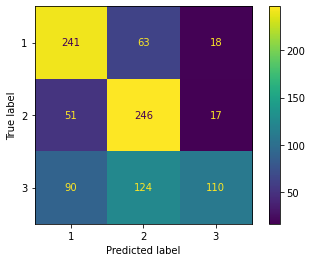


#### results for lowest loss model ####
Accuracy of: 0.5979


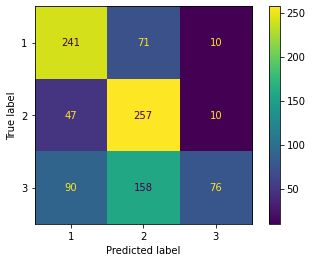


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.8457 @ epoch 2358
Best training loss (min) 0.4056 @ epoch 2358

Best validation accuracy (max) 0.7578 @ epoch 292
Best validation loss (min) 0.6006 @ epoch 294

#### results for highest accuracy model ####
Accuracy of: 0.5839


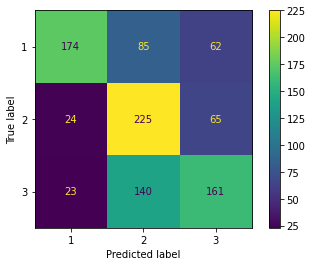


#### results for lowest loss model ####
Accuracy of: 0.5714


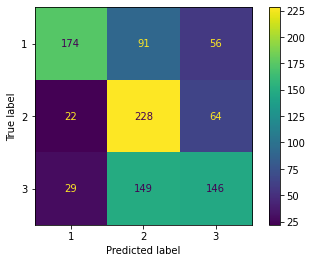


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.8739 @ epoch 2498
Best training loss (min) 0.3447 @ epoch 2478

Best validation accuracy (max) 0.798 @ epoch 2206
Best validation loss (min) 0.6026 @ epoch 1848

#### results for highest accuracy model ####
Accuracy of: 0.6147


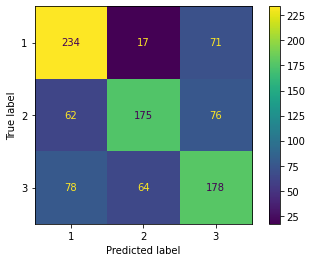


#### results for lowest loss model ####
Accuracy of: 0.6052


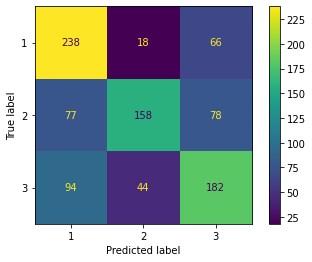

In [6]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/newsubject_longer_window/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject_longer_window/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/newsubject_longer_window/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset